# Executive Summary

Most of piracy events happen from 7pm until 7am with the maximum number of cases between 2 and 3am (see Table 1).

### Table 1a ralationship between number of piracy cases and local time
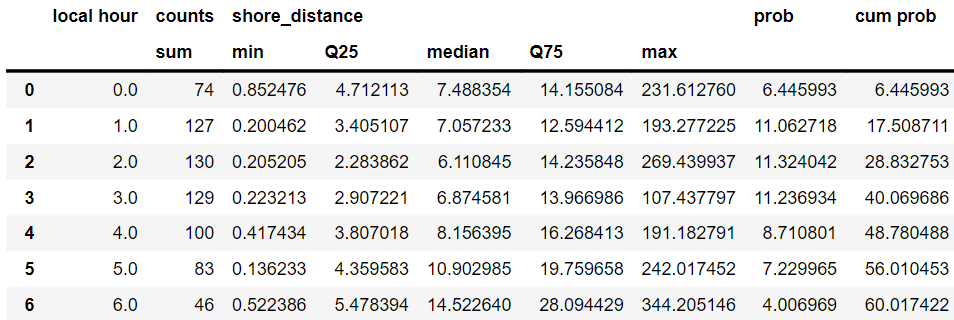
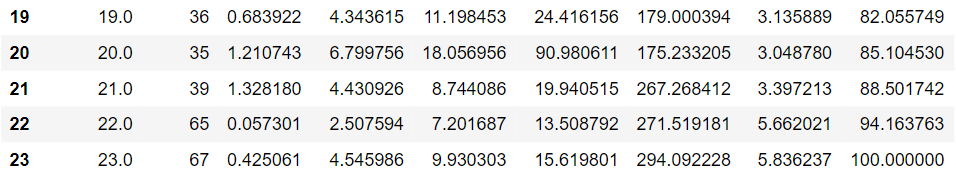

There is difference between time of the attack and type of the attack (see Fig. 1a and Table 2a).

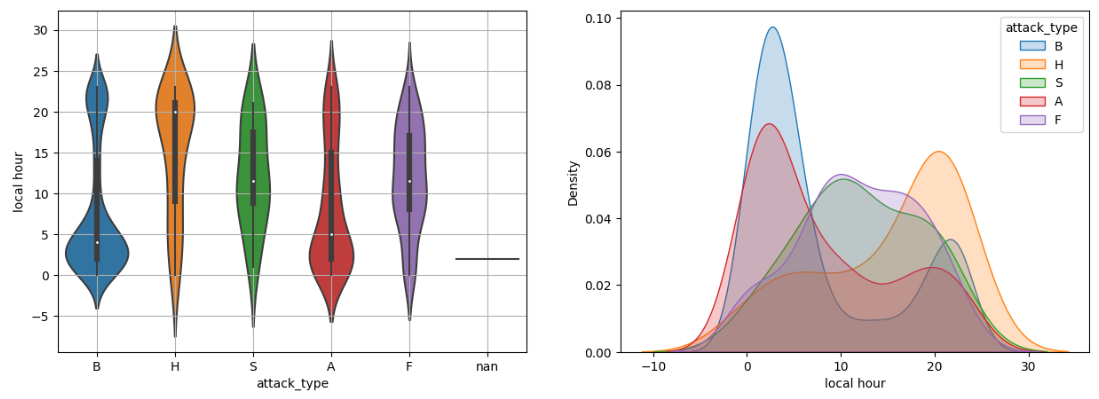
### Fig. 1a Relation between time and type of  attack.

In 50% cases boarding attack happend before 5am (see Table 2a).

### Table 2a Relation between time and type of  attack.
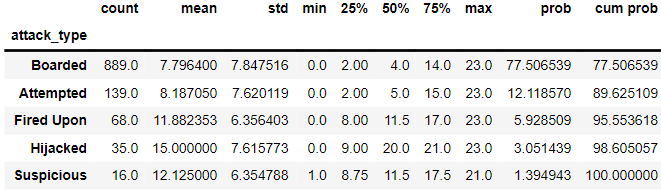

Majority if the attacks happen up to 50km from the coast line (see Fig. 1b).

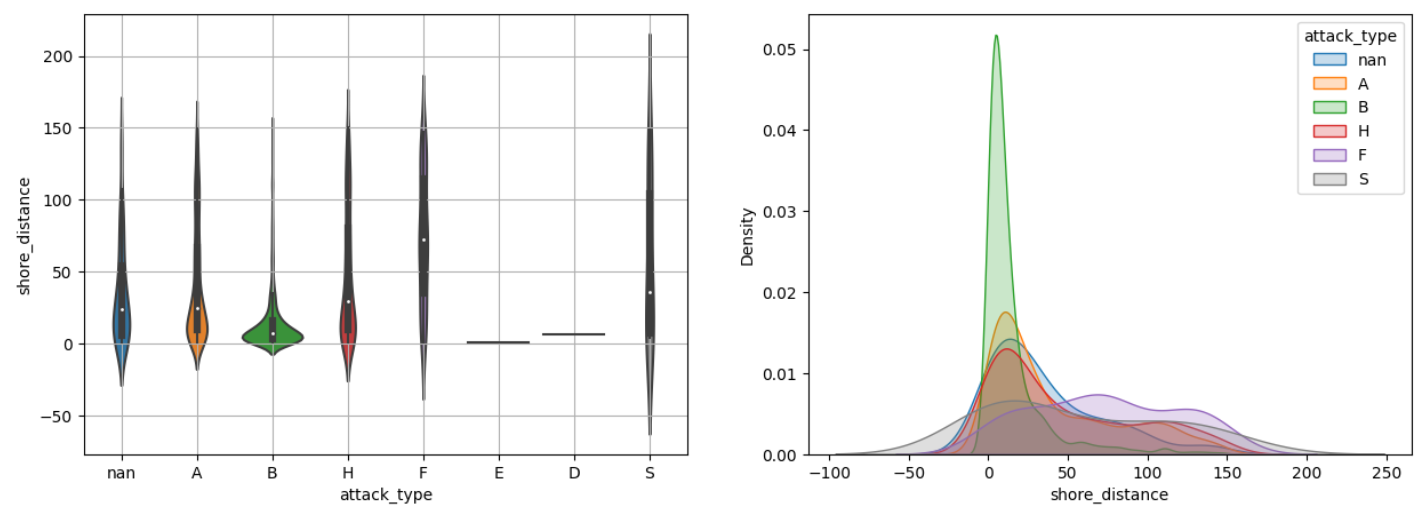
### Fig. 1b Distribution of number of piracy cases with respect to attack type.

For illustration purpose we rename the attack type using the following dictionary:
```python
rename_attack_type = {'Attempted': 'A', 
                      'Hijacked':'H',  
                      'Fired Upon': 'F', 
                      'Boarded': 'B',
                      'Boarding': 'B',
                      'Explosion': 'E', 
                      'Detained': 'D', 
                      'Suspicious': 'S',
                      'nan': 'nan'
                     }
```

In 50% cases when pirats were boarding the ship the distance from the coast was less than 8km and they fire upon when distance is less than 78 km (see Table 2b) 

### Table. 2b Distribution of number of piracy cases with respect to attack type.
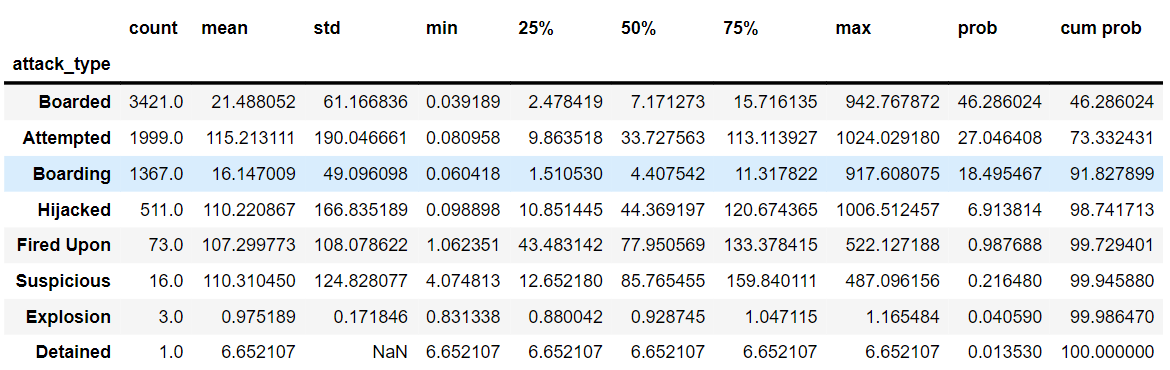

The most frequently pirates attack **Bulk Carrier**, **Product Tanker**, **Container** (see Table 3).

### Table. 3 Distribution of number of piracy cases with respect to carrier type.
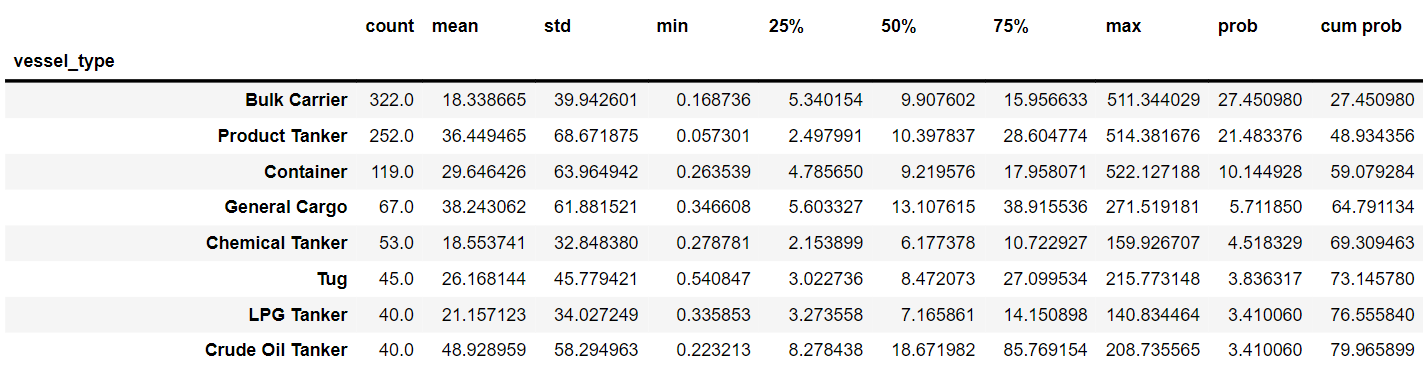

Table 4 shows the number of piracy cases with respect to country.

### Table. 4 Distribution of number of piracy cases with respect to nearest country.
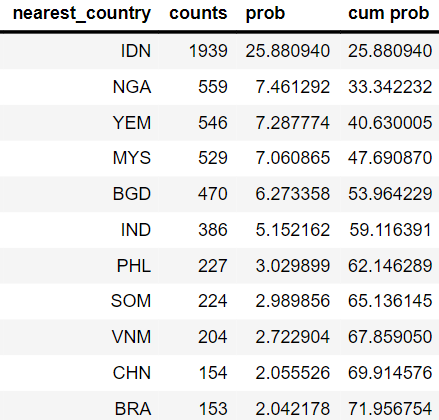

Fig. 3 shows the number of cases given distance to the coast.

In 50% cases boarding attaack happened 
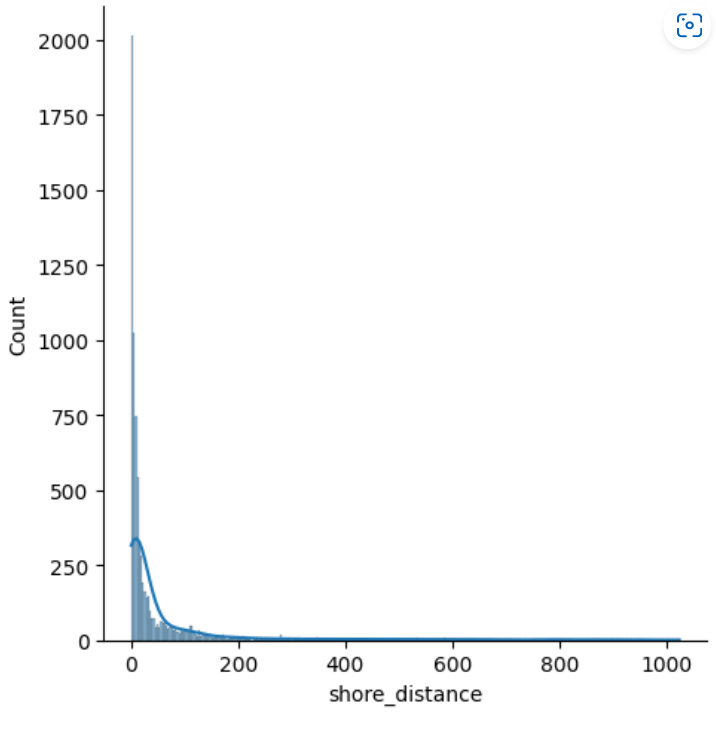
### Fig. 2 Histogram of the number of cases given distance to the coast.

It seems the mojority number of piracy cases happen in Indian Ocean (see Fig. 3)

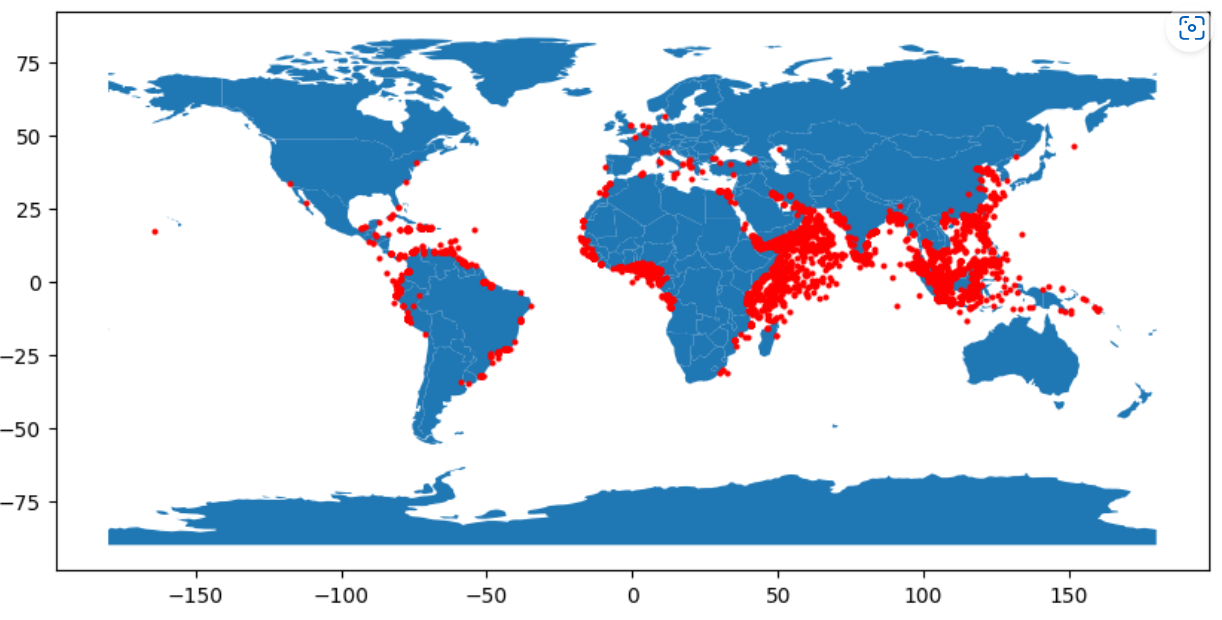
### Fig. 3 Location of piracy attacks 


Fig. 4 shows the closest coast to the attacks.

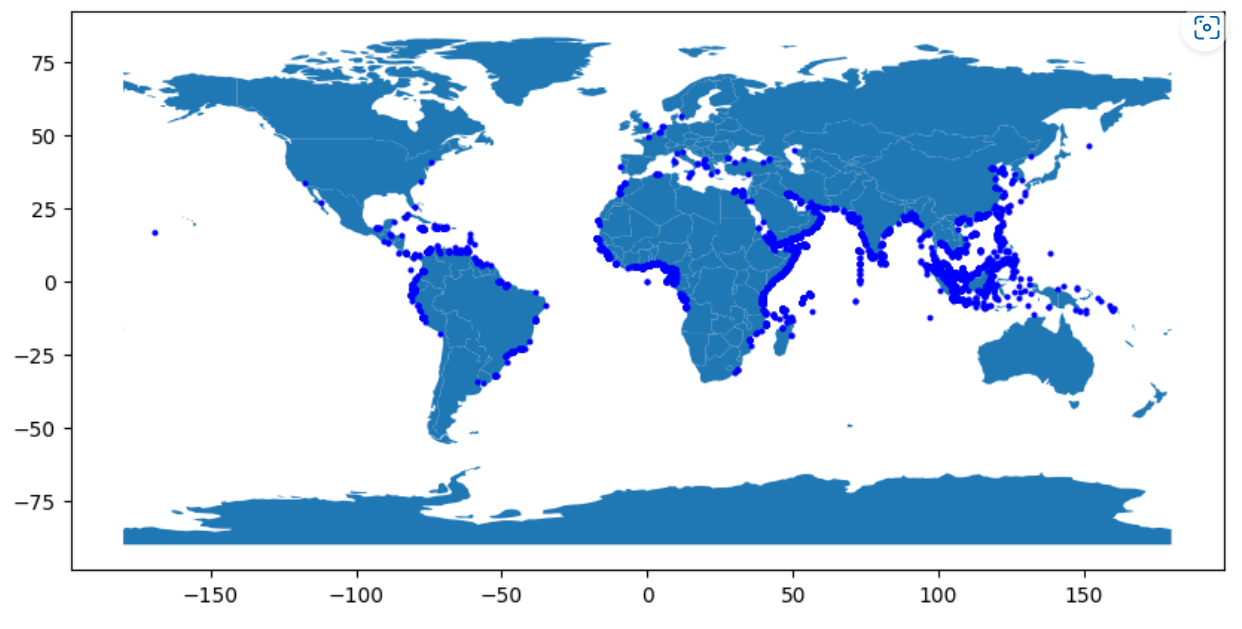
### Fig. 4 The closest coast to the attacks

There is significant difference between country characteristics given it has piracy attack or not except homoside rate (see Table 5).

### Table 5 Significance of country characteristics with respect to piracy attacks
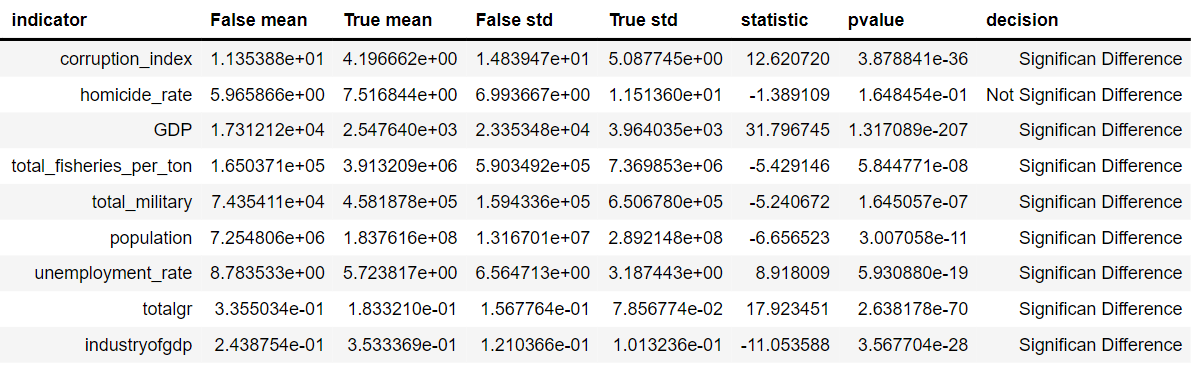

The piracy events have the largest correlation with GDP than any other courntry characteristics (see Fig. 5).

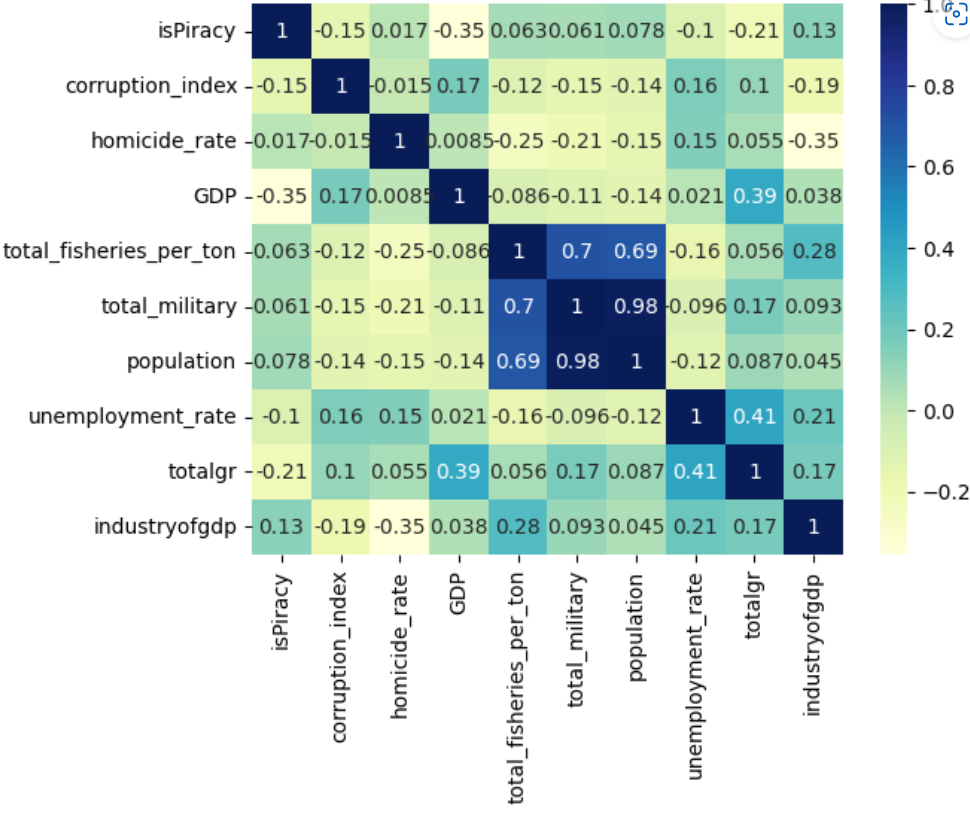
### Fig. 5 Correlation of  courntry characteristics and piracy events.

Visual inspection does not support the hypothesis that the number of piracy case depends on how busy ship routes. For example, there is heavy traffic between US and Europe but there is not many piracy cases (see Fig. 6).

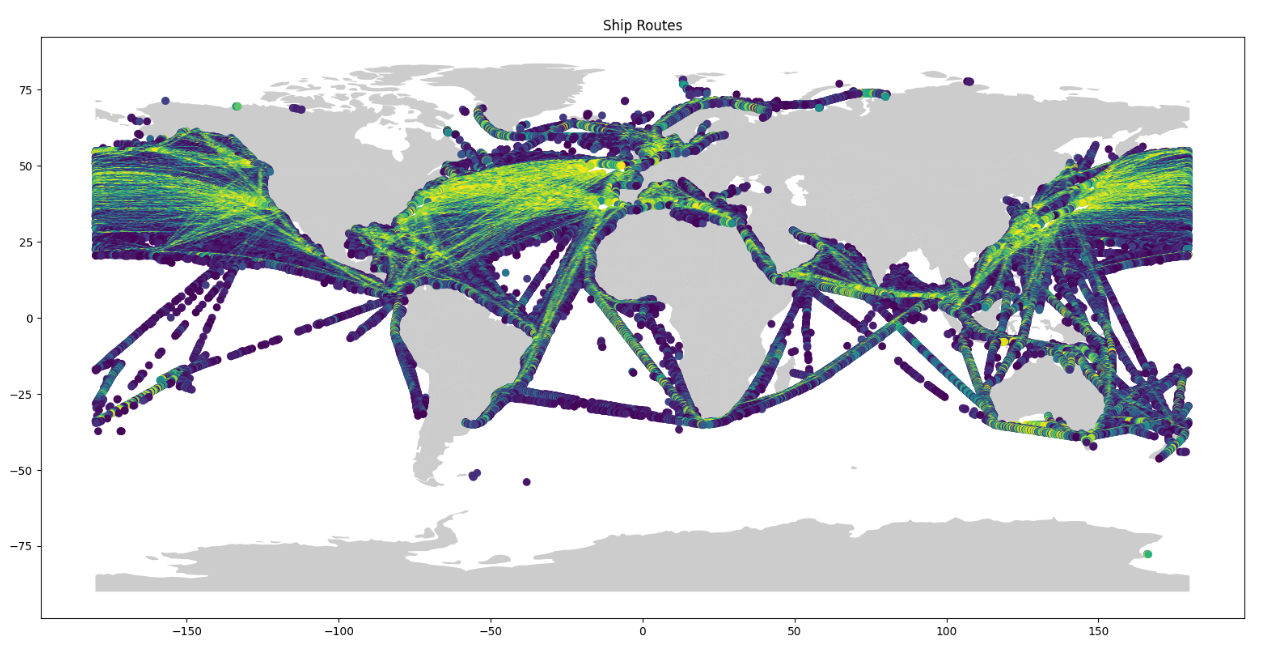
### Fig. 6 The most busiest ship traffic.


It seems there are many US military bases in the places not far from piracy events. Obviously, it does not mean that these bases cause the piracy but maybe they are built partially as responce to piracy (see Fig. 7 and 8). 

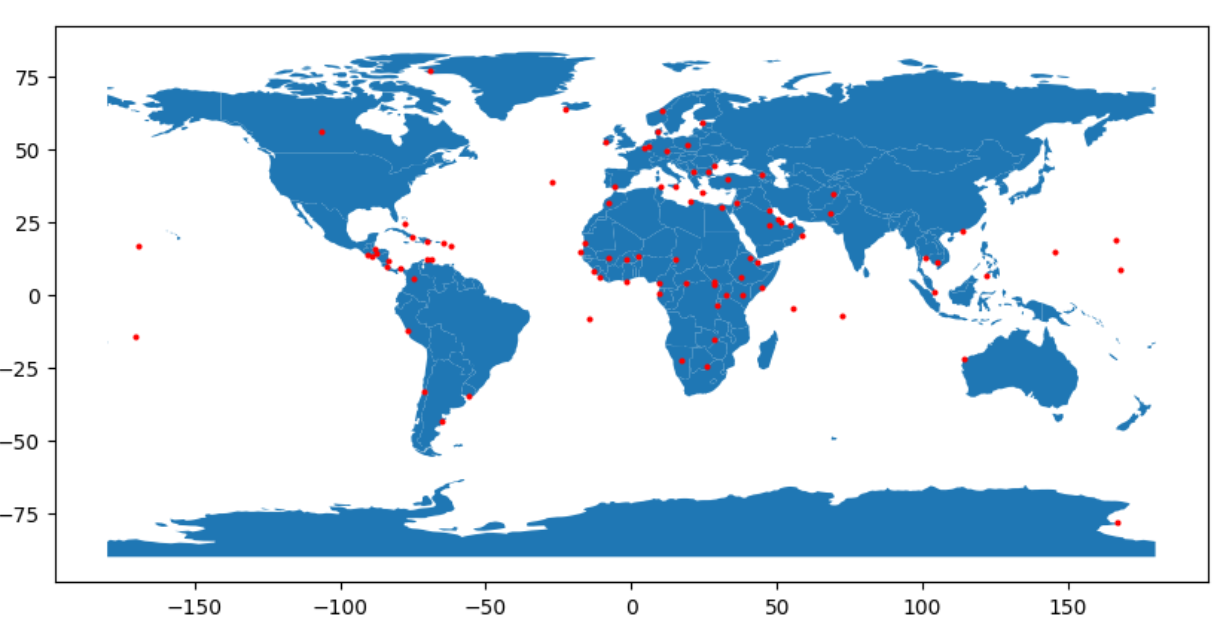
### Fig. 7 US military base locations

We model the piracy events using Random Forest not because we want to have the accurate model but to see the feature impoortance (see Fig. 8).

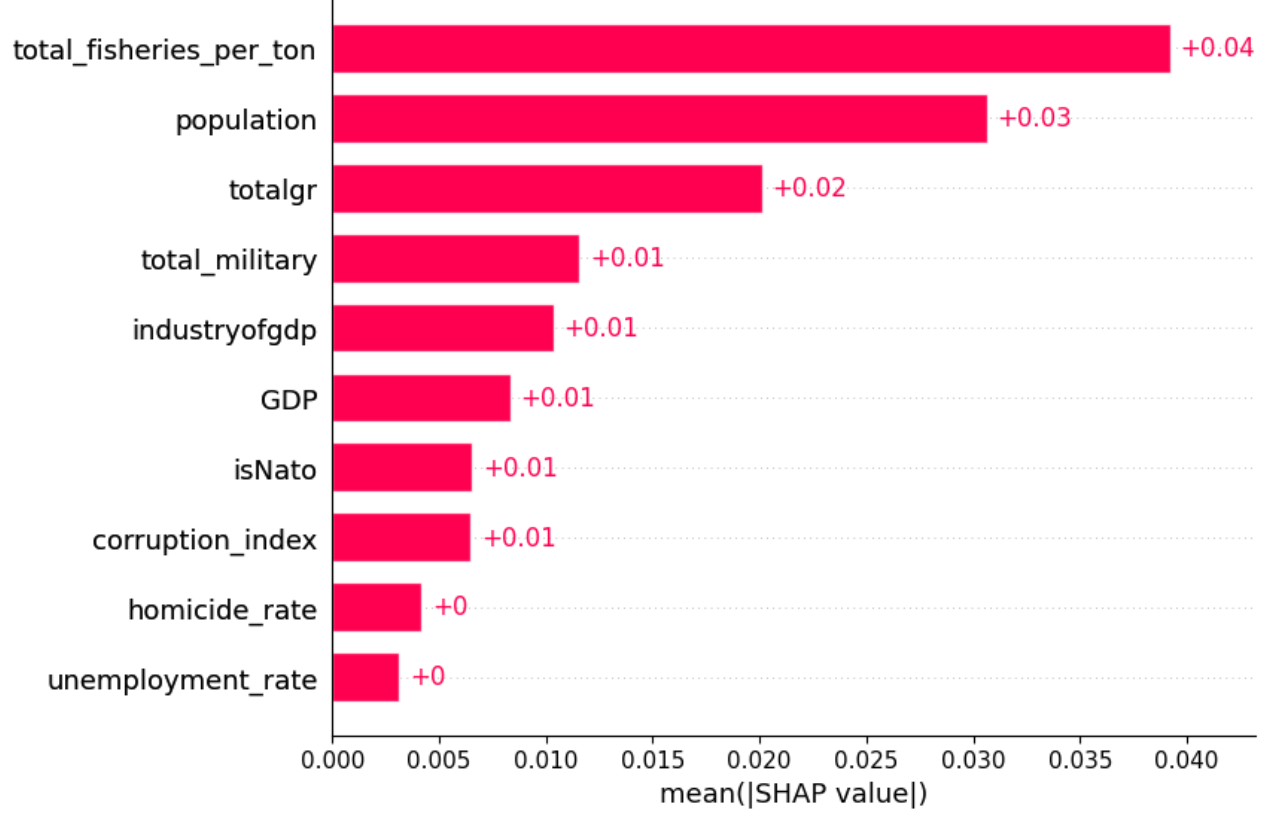
### Fig. 8 Feature importance using SHAP values and Random Forect Classifier for Piracy Event Modelling

In [1]:
!pip install timezonefinder --user

In [5]:
!pip install numpy==1.21.2 --user
!pip install pandas==1.3.2 --user
!pip install scipy==1.7.2 --user
!pip install scikit-learn==1.0 --user
!pip install hyperopt==0.2.7 --user
!pip install matplotlib==3.5.2 --user
!pip install seaborn --user

  Using cached matplotlib-3.5.2-cp39-cp39-win_amd64.whl (7.2 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Alex\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\_c_internal_utils.cp39-win_amd64.pyd'
Check the permissions.



  Using cached matplotlib-3.6.2-cp39-cp39-win_amd64.whl (7.2 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Alex\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\_c_internal_utils.cp39-win_amd64.pyd'
Check the permissions.



In [7]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns

from dateutil import tz
          
from timezonefinder import TimezoneFinder

from scipy import stats

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

from hyperopt import fmin, rand, tpe, Trials, hp, STATUS_OK

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn import metrics

from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier

import shap

from time import time

import warnings

**pirate_attacks.csv**
-	Date [Key] - Date of Attack. Used as a key with the Country Matrix data frame.
-	Time - Time the attack took place, either in UTC or Local Time.
-	Longitude - Longitude where the attack took place.
-	Latitude - Latitude where the attack took place.
-	Attack Type - Either NA (Missing), Attempted, Boarding, or Hijacked.
-	Location Description - A text description of the location. With attacks taking place at sea, it is not as simple as just naming a city or town.
-	Nearest Country [Key] - The country code whose shore is closest to the attack. The resolution is around 1 km, it can be much better depending on how detailed the mapping of the coast is in the vicinity.
-	EEZ Country [Key] - The Exclusive Economic Zone country code in which the attack took place, if it took place within an EEZ.
-	Shore Distance - Distance in kilometres to the shore from the attack location. This is the true geographic distance over the surface of the earth.
-	Shore Longitude - The longitude of the closest point on the shore to the attack.
-	Shore Latitude - The latitude of the closest point on the shore to the attack.
-	Attack Description - The text description of the attack if it exists.
-	Vessel Name - The name of the ship which was attacked if it is known.
-	Vessel Type - The type of vessel attacked if known.
-	Vessel Status - The status of the ship at the time it was attacked. Either NA (Missing), Berthed (Tied to a berth), Anchored (anchored at sea or in a harbour), or Steaming (ship underway).


In [8]:

def compare_variables(df, slice_values, groupby='y', title = "", order = []):
                   
    for gl in slice_values:
            fig, ax = plt.subplots(1,2,figsize=[15,5])
            if len(order) > 0:
               sns.violinplot(x=groupby, y=gl, data=df, order = order, height = 5, aspect = 1.7, ax = ax[0]).set_title(title)
            else:
               sns.violinplot(x=groupby, y=gl, data=df,                height = 5, aspect = 1.7, ax = ax[0]).set_title(title) 
            #
            groups = df.groupby(groupby)
            for t in df[groupby].unique():
                dftmp = groups.get_group(t)
                try:
                   sns.kdeplot(dftmp[gl], ax = ax[1], shade = True, label = t).set_title(title)
                except Exception as e:
                   print("Exception: ", str(e))
            #
            ax[1].set_xlabel(gl)
            ax[1].legend(title = groupby)
            ax[0].grid()
    plt.show()
    return plt   

def UTC_to_local_hour_given_log_lat(size, index, x, longitude, latitude):
    if index % 100 == 0:
       print("Current index: ", index, ", proportion of time converted: ", index * 100 / size)
    if not pd.isna(x):         
       if "UTC" in x:
          obj = TimezoneFinder()
          try: 
            lat_lon_time_zone = obj.timezone_at(lng=longitude, lat=latitude)
            from_zone = tz.gettz('UTC')
            to_zone = tz.gettz(lat_lon_time_zone)

            x = x.replace("UTC", "").strip()
            utc = datetime.strptime(x, '%H:%M')
          
            utc = utc.replace(tzinfo=from_zone)

            # Convert time zone
            hour = int(utc.astimezone(to_zone).hour)
          except:
            hour = np.nan
       else: #local time
          hour = int(x.strip().split(":")[0])
    else:
       hour = np.nan
    return hour

In [10]:
name = "pirate_attacks.csv"
test_pirate_attacks = pd.read_csv(name)
print(len(test_pirate_attacks["eez_country"].unique()))
display(test_pirate_attacks["eez_country"].unique())

print(len(test_pirate_attacks["nearest_country"].unique()))
display(test_pirate_attacks["nearest_country"].unique())

103


array(['TWN', 'CHN', 'PHL', 'KHM', 'VNM', 'AGO', nan, 'NGA', 'TZA', 'KOR',
       'PAK', 'SOM', 'IDN', 'BRA', 'JPN', 'MYS', 'LKA', 'COL', 'GUY',
       'BGD', 'EGY', 'JAM', 'DJI', 'SEN', 'CIV', 'PNG', 'ECU', 'IRN',
       'RUS', 'PAN', 'DZA', 'TUR', 'YEM', 'THA', 'DNK', 'IND', 'PER',
       'ITA', 'GIN', 'GAB', 'BRN', 'URY', 'SYC', 'DOM', 'GHA', 'GRC',
       'SLE', 'GEO', 'MDG', 'CMR', 'MMR', 'ERI', 'ALB', 'NLD', 'PRT',
       'VEN', 'USA', 'SLB', 'MLT', 'KEN', 'FRA', 'MAR', 'SGP', 'COD',
       'MEX', 'GNB', 'OMN', 'HTI', 'HND', 'MOZ', 'BLZ', 'MRT', 'TGO',
       'ZAF', 'GNQ', 'COG', 'STP', 'BEL', 'TTO', 'SAU', 'IRQ', 'BGR',
       'GBR', 'SLV', 'GUF', 'CRI', 'GMB', 'CUB', 'MTQ', 'LBR', 'LCA',
       'AUS', 'BEN', 'ARE', 'ARG', 'SDN', 'SUR', 'MUS', 'KAZ', 'PLW',
       'MDV', 'MYT', 'GTM'], dtype=object)

104


array(['CHN', 'PHL', 'KHM', 'VNM', 'AGO', nan, 'NGA', 'TZA', 'KOR', 'PAK',
       'SOM', 'IDN', 'BRA', 'JPN', 'MYS', 'LKA', 'COL', 'COD', 'GUY',
       'BGD', 'EGY', 'JAM', 'DJI', 'TWN', 'SEN', 'CIV', 'PNG', 'ECU',
       'IRN', 'RUS', 'PAN', 'DZA', 'TUR', 'YEM', 'THA', 'DNK', 'IND',
       'PER', 'ITA', 'GIN', 'GAB', 'URY', 'SYC', 'DOM', 'GHA', 'GRC',
       'SLE', 'GEO', 'MDG', 'CMR', 'MMR', 'ERI', 'ALB', 'NLD', 'PRT',
       'VEN', 'USA', 'SLB', 'MLT', 'SGP', 'KEN', 'FRA', 'MAR', 'MEX',
       'GNB', 'OMN', 'HTI', 'HND', 'MOZ', 'BLZ', 'MRT', 'TGO', 'ZAF',
       'GNQ', 'COG', 'STP', 'TTO', 'SAU', 'IRQ', 'CCK', 'BGR', 'GBR',
       'SLV', 'GUF', 'CRI', 'GMB', 'CUB', 'MTQ', 'LBR', 'BRB', 'LCA',
       'GLP', 'AUS', 'BEN', 'GRD', 'ARE', 'ARG', 'SDN', 'SUR', 'MUS',
       'KAZ', 'MDV', 'MYT', 'GTM'], dtype=object)

In [11]:

name = "pirate_attacks.csv"
pirate_attacks = pd.read_csv(name)
display(pirate_attacks.describe())
pirate_attacks.head()

longitude     latitude  shore_distance  shore_longitude  \
count  7511.000000  7511.000000     7511.000000      7511.000000   
mean     59.334247     6.505837       53.711327        59.280798   
std      58.533689    10.532129      126.592636        58.549858   
min    -163.992800   -34.903333        0.039189      -169.512766   
25%      10.133750     0.841667        2.922736         9.846121   
50%      83.416667     5.033333       10.108765        83.341319   
75%     105.173594    13.150000       36.219880       105.246349   
max     160.264600    56.587800     1024.029180       160.257579   

       shore_latitude  
count     7511.000000  
mean         6.599277  
std         10.609951  
min        -34.898696  
25%          0.893744  
50%          5.242255  
75%         13.585598  
max         56.684719

date time  longitude   latitude attack_type  \
0  1993-01-02  NaN   116.9667  19.700000         NaN   
1  1993-01-04  NaN   116.0000  22.350000         NaN   
2  1993-01-06  NaN   115.2500  19.670000         NaN   
3  1993-01-08  NaN   124.5833  29.900000         NaN   
4  1993-01-12  NaN   120.2667  18.133333         NaN   

         location_description nearest_country eez_country  shore_distance  \
0  Hong Kong - Luzon - Hainan             CHN         TWN      357.502373   
1  Hong Kong - Luzon - Hainan             CHN         CHN       47.431573   
2  Hong Kong - Luzon - Hainan             CHN         TWN      280.811871   
3              East China Sea             CHN         CHN      209.923396   
4  Hong Kong - Luzon - Hainan             PHL         PHL       22.027332   

   shore_longitude  shore_latitude attack_description           vessel_name  \
0       115.825956       22.746644                NaN      Mv Cosmic Leader   
1       115.825956       22.746644                NaN  Mv Tricolor Star III   
2       114.302501       22.044867                NaN        Mv Arktis Star   
3       122.409679       29.911200                NaN             Ussurijsk   
4       120.470063       18.091010                NaN     Mv Chennai Nermai   

  vessel_type vessel_status    data_source  
0         NaN           NaN  mappingpiracy  
1         NaN           NaN  mappingpiracy  
2         NaN           NaN  mappingpiracy  
3         NaN           NaN  mappingpiracy  
4         NaN           NaN  mappingpiracy

In [17]:
# here are a few ways to convert time zone
from datetime import datetime

hour_pirate_attacks = pirate_attacks.copy()
hour_pirate_attacks = hour_pirate_attacks.dropna(subset = ["shore_distance", "time", "longitude", "latitude"])

hour_pirate_attacks["order"] = range(len(hour_pirate_attacks))
size = len(hour_pirate_attacks)

hour_pirate_attacks["local hour"] = hour_pirate_attacks.apply(lambda x: UTC_to_local_hour_given_log_lat(size, 
                                                                                                        x["order"], 
                                                                                                        x["time"], 
                                                                                                        x["longitude"], 
                                                                                                        x["latitude"]), 
                                                                                                        axis = 1)   
hour_pirate_attacks.head(10)

Current index:  0 , proportion of time converted:  0.0
Current index:  100 , proportion of time converted:  8.703220191470844
Current index:  200 , proportion of time converted:  17.40644038294169
Current index:  300 , proportion of time converted:  26.109660574412533
Current index:  400 , proportion of time converted:  34.81288076588338
Current index:  500 , proportion of time converted:  43.51610095735422
Current index:  600 , proportion of time converted:  52.21932114882507
Current index:  700 , proportion of time converted:  60.92254134029591
Current index:  800 , proportion of time converted:  69.62576153176676
Current index:  900 , proportion of time converted:  78.3289817232376
Current index:  1000 , proportion of time converted:  87.03220191470844
Current index:  1100 , proportion of time converted:  95.73542210617929


date       time   longitude   latitude attack_type  \
6338  2015-01-08      02:34  104.166667   1.116667     Boarded   
6339  2015-01-08      14:30  103.616667   1.183333     Boarded   
6340  2015-01-09      07:00  -75.550000  10.300000     Boarded   
6341  2015-01-10      05:00  104.166667   1.080000     Boarded   
6342  2015-01-11      05:00    4.983333   3.733333    Hijacked   
6343  2015-01-14  21:30 UTC    1.350000   3.400000     Boarded   
6344  2015-01-14      05:50  103.900000   1.035000     Boarded   
6345  2015-01-18      06:32  103.516667   1.116667     Boarded   
6346  2015-01-20      17:10   -3.833333   4.050000  Suspicious   
6347  2015-01-22      03:50  103.533333   1.100000     Boarded   

                               location_description nearest_country  \
6338                   Kabil Anchorage, Pulau Batam             IDN   
6339                 Around 2.7nm NW of Pulau Nipah             SGP   
6340                            Cartagena Anchorage             COL   
6341          Tanjung Uban Anchorage, Pulau Bintan,             IDN   
6342                      Around 63nm SW of Bayelsa             NGA   
6343                      Around 157nm SSE of Accra             GHA   
6344  PT Idros Private Jetty, Tanjung Uncang, Batam             IDN   
6345         Around 6nm East of Pulau Karimun Kecil             IDN   
6346                     Around 70nm SSE of Abidjan             CIV   
6347          Around 7nm ENE of Pulau Karimun Besar             IDN   

     eez_country  shore_distance  shore_longitude  shore_latitude  \
6338         IDN        1.693641       104.151703        1.119452   
6339         IDN       14.254047       103.647634        1.308417   
6340         COL        2.046203       -75.563385       10.287095   
6341         IDN        4.669503       104.151703        1.119452   
6342         NGA      118.914531         5.749766        4.484442   
6343         GHA      267.268412         0.914399        5.777086   
6344         IDN        2.253638       103.880056        1.031480   
6345         IDN       12.471779       103.428396        1.047187   
6346         CIV      126.114107        -3.678538        5.179836   
6347         IDN       12.993251       103.431407        1.042711   

                                     attack_description vessel_name  \
6338  08.01.2015: 0234 LT: Posn: Kabil Port, Batam, ...         NaN   
6339  08.01.2015: 1430 LT: Posn: 01:11N - 103:37E, A...         NaN   
6340  09.01.2015: 0700 LT: Posn: 10:18.31N – 075:33....         NaN   
6341  10.01.2015: 0500 LT: Posn: 01:04.8N – 104:10.9...         NaN   
6342  11.01.2015: 0500 LT: Posn: 03:44N – 004:59E, A...         NaN   
6343  14.01.2015: 2130 UTC: Posn: 03:24N – 001:21E, ...         NaN   
6344  14.01.2015: 0550 LT: Posn: 01:02.1N – 103:54.8...         NaN   
6345  18.01.2015: 0632 LT: Posn: 01:07N – 103:31E, A...         NaN   
6346  Suspicious approach: This incident will not fe...         NaN   
6347  22.01.2015: 0350 LT: Posn: 01:06N – 103:32E, A...         NaN   

               vessel_type vessel_status data_source  order  local hour  
6338       Chemical Tanker      Anchored         imb      0         2.0  
6339         Tug and Barge           NaN         imb      1        14.0  
6340         General Cargo      Anchored         imb      2         7.0  
6341            LPG Tanker      Anchored         imb      3         5.0  
6342        Product Tanker           NaN         imb      4         5.0  
6343          Bulk Carrier           NaN         imb      5        21.0  
6344         Tug and Barge       Berthed         imb      6         5.0  
6345          Bulk Carrier           NaN         imb      7         6.0  
6346  Offshore Supply Ship           NaN         imb      8        17.0  
6347          Bulk Carrier           NaN         imb      9         3.0

In [8]:
def Q25(x):
    return np.quantile(x, 0.25)

def Q75(x):
    return np.quantile(x, 0.75)

hours_pirate_attacks = hour_pirate_attacks.copy()

hours_pirate_attacks["counts"] = 1
hours_pirate_attacks = hours_pirate_attacks.groupby(["local hour"]).agg({"counts": sum, "shore_distance": ["min", Q25, np.median, Q75, "max"]}).reset_index()
hours_pirate_attacks["prob"] = hours_pirate_attacks["counts"] * 100 / hours_pirate_attacks["counts"].sum() 
hours_pirate_attacks["cum prob"] = np.cumsum(hours_pirate_attacks["counts"]) * 100 / hours_pirate_attacks["counts"].sum() 
hours_pirate_attacks

local hour counts shore_distance                                    \
                 sum            min        Q25     median         Q75   
0         0.0     74       0.852476   4.712113   7.488354   14.155084   
1         1.0    127       0.200462   3.405107   7.057233   12.594412   
2         2.0    130       0.205205   2.283862   6.110845   14.235848   
3         3.0    129       0.223213   2.907221   6.874581   13.966986   
4         4.0    100       0.417434   3.807018   8.156395   16.268413   
5         5.0     83       0.136233   4.359583  10.902985   19.759658   
6         6.0     46       0.522386   5.478394  14.522640   28.094429   
7         7.0     27       1.171028   7.005605  10.334894   40.141390   
8         8.0     27       1.309027  12.843721  38.558560   99.114177   
9         9.0     20       2.446086  18.290378  63.148237   94.045234   
10       10.0     23       0.675887  12.200713  36.894702  121.711181   
11       11.0     14       6.969202  17.342731  42.422790   63.603476   
12       12.0     13       1.428924  11.421462  17.429258  116.374508   
13       13.0     20       0.263539  11.425292  54.216157  141.127244   
14       14.0     11       2.473053   9.036744  16.678390   69.183515   
15       15.0     17       2.550182  10.186735  34.244674   87.524018   
16       16.0     15       1.021770  16.532472  93.291582  136.102300   
17       17.0     15       1.509798   6.159190  27.099534   78.910498   
18       18.0     15       9.499252  17.211268  53.895020   83.235108   
19       19.0     36       0.683922   4.343615  11.198453   24.416156   
20       20.0     35       1.210743   6.799756  18.056956   90.980611   
21       21.0     39       1.328180   4.430926   8.744086   19.940515   
22       22.0     65       0.057301   2.507594   7.201687   13.508792   
23       23.0     67       0.425061   4.545986   9.930303   15.619801   

                     prob    cum prob  
           max                         
0   231.612760   6.445993    6.445993  
1   193.277225  11.062718   17.508711  
2   269.439937  11.324042   28.832753  
3   107.437797  11.236934   40.069686  
4   191.182791   8.710801   48.780488  
5   242.017452   7.229965   56.010453  
6   344.205146   4.006969   60.017422  
7   189.712628   2.351916   62.369338  
8   197.572596   2.351916   64.721254  
9   514.381676   1.742160   66.463415  
10  364.871451   2.003484   68.466899  
11  142.713501   1.219512   69.686411  
12  522.127188   1.132404   70.818815  
13  215.773148   1.742160   72.560976  
14  180.855988   0.958188   73.519164  
15  511.344029   1.480836   75.000000  
16  206.477353   1.306620   76.306620  
17  252.713371   1.306620   77.613240  
18  232.252335   1.306620   78.919861  
19  179.000394   3.135889   82.055749  
20  175.233205   3.048780   85.104530  
21  267.268412   3.397213   88.501742  
22  271.519181   5.662021   94.163763  
23  294.092228   5.836237  100.000000

['nan' 'Attempted' 'Boarded' 'Hijacked' 'Boarding' 'Fired Upon'
 'Explosion' 'Detained' 'Suspicious']
rename_attack_type:  {'Attempted': 'A', 'Hijacked': 'H', 'Fired Upon': 'F', 'Boarded': 'B', 'Boarding': 'B', 'Explosion': 'E', 'Detained': 'D', 'Suspicious': 'S', 'nan': 'nan'}


C:\Users\Alex\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\Alex\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


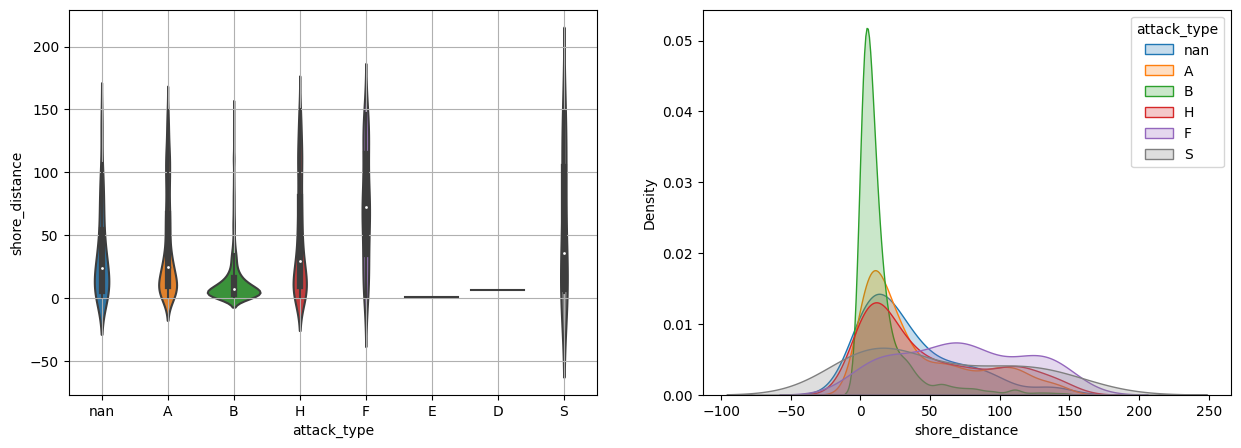

<module 'matplotlib.pyplot' from 'C:\\Users\\Alex\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\pyplot.py'>

In [9]:
rename_attack_type = {'Attempted': 'A', 
                      'Hijacked':'H',  
                      'Fired Upon': 'F', 
                      'Boarded': 'B',
                      'Boarding': 'B',
                      'Explosion': 'E', 
                      'Detained': 'D', 
                      'Suspicious': 'S',
                      'nan': 'nan'
                     }

str_pirate_attacks = pirate_attacks.copy()
str_pirate_attacks= str_pirate_attacks[(str_pirate_attacks["shore_distance"]<=150) & (str_pirate_attacks["shore_distance"]>=1)].copy()
str_pirate_attacks['attack_type'] = str_pirate_attacks['attack_type'].astype(str)
print(str_pirate_attacks['attack_type'].unique())

str_pirate_attacks['attack_type'] = str_pirate_attacks['attack_type'].apply(lambda x: rename_attack_type[str(x)])
print("rename_attack_type: ", rename_attack_type)
compare_variables(str_pirate_attacks, slice_values = ["shore_distance"], groupby='attack_type', title = "", order = [])

['Boarded' 'Hijacked' 'Suspicious' 'Attempted' 'Fired Upon' 'nan']
rename_attack_type:  {'Attempted': 'A', 'Hijacked': 'H', 'Fired Upon': 'F', 'Boarded': 'B', 'Boarding': 'B', 'Explosion': 'E', 'Detained': 'D', 'Suspicious': 'S', 'nan': 'nan'}


Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


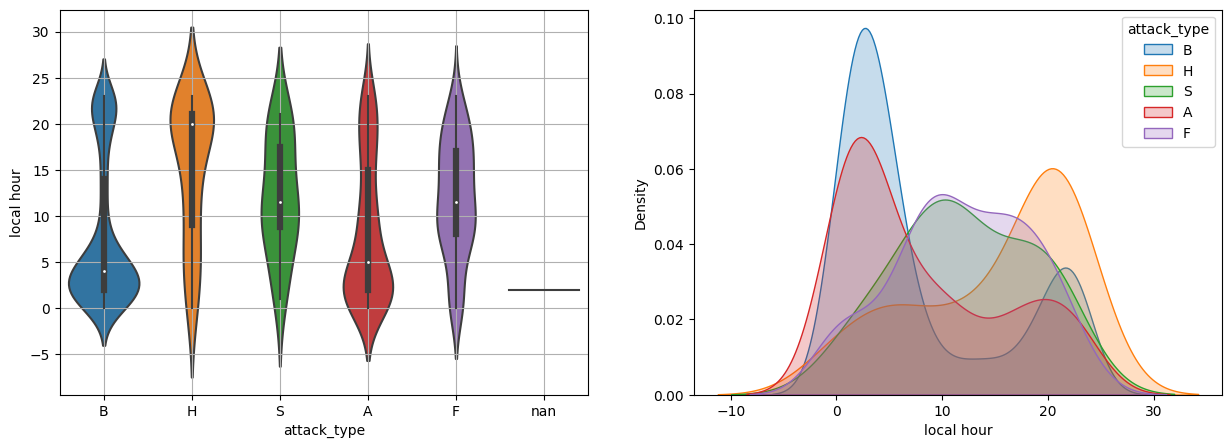

<module 'matplotlib.pyplot' from 'C:\\Users\\Alex\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\pyplot.py'>

In [18]:
rename_attack_type = {'Attempted': 'A', 
                      'Hijacked':'H',  
                      'Fired Upon': 'F', 
                      'Boarded': 'B',
                      'Boarding': 'B',
                      'Explosion': 'E', 
                      'Detained': 'D', 
                      'Suspicious': 'S',
                      'nan': 'nan'
                     }

str_pirate_attacks = hour_pirate_attacks.copy()
str_pirate_attacks['attack_type'] = str_pirate_attacks['attack_type'].astype(str)
print(str_pirate_attacks['attack_type'].unique())

str_pirate_attacks['attack_type'] = str_pirate_attacks['attack_type'].apply(lambda x: rename_attack_type[str(x)])
print("rename_attack_type: ", rename_attack_type)
compare_variables(str_pirate_attacks, slice_values = ["local hour"], groupby='attack_type', title = "", order = [])

In [21]:
str_pirate_attacks = hour_pirate_attacks.copy()
data_stats = str_pirate_attacks.groupby('attack_type')["local hour"].describe().sort_values(by = "count", ascending = False)
data_stats["prob"] = data_stats["count"] * 100 / data_stats["count"].sum() 
data_stats["cum prob"] = np.cumsum(data_stats["count"]) * 100 / data_stats["count"].sum() 
display(data_stats)

count       mean       std  min   25%   50%   75%   max  \
attack_type                                                            
Boarded      889.0   7.796400  7.847516  0.0  2.00   4.0  14.0  23.0   
Attempted    139.0   8.187050  7.620119  0.0  2.00   5.0  15.0  23.0   
Fired Upon    68.0  11.882353  6.356403  0.0  8.00  11.5  17.0  23.0   
Hijacked      35.0  15.000000  7.615773  0.0  9.00  20.0  21.0  23.0   
Suspicious    16.0  12.125000  6.354788  1.0  8.75  11.5  17.5  21.0   

                  prob    cum prob  
attack_type                         
Boarded      77.506539   77.506539  
Attempted    12.118570   89.625109  
Fired Upon    5.928509   95.553618  
Hijacked      3.051439   98.605057  
Suspicious    1.394943  100.000000

In [10]:
str_pirate_attacks = pirate_attacks.copy()
str_pirate_attacks = str_pirate_attacks[["shore_distance", 'attack_type']].copy()
str_pirate_attacks = str_pirate_attacks.dropna()

data_stats = str_pirate_attacks.groupby('attack_type')["shore_distance"].describe().sort_values(by = "count", ascending = False)
data_stats["prob"] = data_stats["count"] * 100 / data_stats["count"].sum() 
data_stats["cum prob"] = np.cumsum(data_stats["count"]) * 100 / data_stats["count"].sum() 
display(data_stats)

count        mean         std       min        25%        50%  \
attack_type                                                                   
Boarded      3421.0   21.488052   61.166836  0.039189   2.478419   7.171273   
Attempted    1999.0  115.213111  190.046661  0.080958   9.863518  33.727563   
Boarding     1367.0   16.147009   49.096098  0.060418   1.510530   4.407542   
Hijacked      511.0  110.220867  166.835189  0.098898  10.851445  44.369197   
Fired Upon     73.0  107.299773  108.078622  1.062351  43.483142  77.950569   
Suspicious     16.0  110.310450  124.828077  4.074813  12.652180  85.765455   
Explosion       3.0    0.975189    0.171846  0.831338   0.880042   0.928745   
Detained        1.0    6.652107         NaN  6.652107   6.652107   6.652107   

                    75%          max       prob    cum prob  
attack_type                                                  
Boarded       15.716135   942.767872  46.286024   46.286024  
Attempted    113.113927  1024.029180  27.046408   73.332431  
Boarding      11.317822   917.608075  18.495467   91.827899  
Hijacked     120.674365  1006.512457   6.913814   98.741713  
Fired Upon   133.378415   522.127188   0.987688   99.729401  
Suspicious   159.840111   487.096156   0.216480   99.945880  
Explosion      1.047115     1.165484   0.040590   99.986470  
Detained       6.652107     6.652107   0.013530  100.000000

In [11]:
str_pirate_attacks = pirate_attacks.copy()
str_pirate_attacks = str_pirate_attacks[["shore_distance", 'vessel_type']].copy()
str_pirate_attacks = str_pirate_attacks.dropna()

data_stats = str_pirate_attacks.groupby('vessel_type')["shore_distance"].describe().sort_values(by = "count", ascending = False)
data_stats["prob"] = data_stats["count"] * 100 / data_stats["count"].sum() 
data_stats["cum prob"] = np.cumsum(data_stats["count"]) * 100 / data_stats["count"].sum() 
display(data_stats)

count        mean         std  \
vessel_type                                                                 
Bulk Carrier                                322.0   18.338665   39.942601   
Product Tanker                              252.0   36.449465   68.671875   
Container                                   119.0   29.646426   63.964942   
General Cargo                                67.0   38.243062   61.881521   
Chemical Tanker                              53.0   18.553741   32.848380   
Tug                                          45.0   26.168144   45.779421   
LPG Tanker                                   40.0   21.157123   34.027249   
Crude Oil Tanker                             40.0   48.928959   58.294963   
Tanker                                       30.0   46.062979   78.900016   
Fishing Vessel                               27.0   46.587693   93.906620   
Crude Tanker                                 23.0   30.365240   47.619316   
Refrigerated Cargo                           16.0   38.295091   35.247681   
Offshore Supply Ship                         15.0   18.248877   33.719021   
Offshore Tug                                  9.0   13.105535   19.263291   
LNG Tanker                                    9.0   39.439010   46.064882   
Asphalt/Bitumen Tanker                        8.0   37.682829   38.469148   
Heavy Load Carrier                            7.0   35.473966   51.066275   
Offshore Support Vessel                       7.0   31.194331   45.798528   
Research Vessel                               6.0   38.139896   86.115276   
Pipe Layer                                    6.0    9.534739    8.635554   
Vehicle Carrier                               6.0   16.441188   25.131293   
Offshore Supply ship                          6.0   27.105894   40.971457   
Tug and Barge                                 5.0   19.766231   23.585320   
Ore Carrier                                   4.0   30.660416    9.382431   
PRODUCT TANKER                                4.0   66.343465  110.243336   
Bunkering Tanker                              3.0   26.883025   31.205326   
BULK CARRIER                                  3.0   29.257883   38.546193   
Offshore Supply                               3.0   83.863827   90.419838   
Dhow                                          3.0   36.544066   30.585482   
Support                                       3.0    6.555989    5.440335   
Wood Chips Carrier                            2.0   18.941321   10.426740   
Ro-Ro                                         2.0  100.088084  131.789347   
Tug / Barge                                   2.0   13.862212    7.595131   
Yacht                                         2.0    1.825237    1.042468   
Other                                         2.0    2.133784    0.102207   
Dredger                                       2.0   13.009143   15.495677   
OFFSHORE SUPPLY SHIP                          2.0    4.199976    1.597738   
Landing Craft                                 2.0  179.302978   81.737183   
Supply Vessel                                 1.0    2.605394         NaN   
CONTAINER                                     1.0    0.205205         NaN   
Cable Ship                                    1.0    5.083958         NaN   
Cement Carrier                                1.0    0.667854         NaN   
FPSO                                          1.0   56.623621         NaN   
Floating Production Storage and Offloading    1.0   13.297183         NaN   
Floating Storage and Offloading               1.0   23.231022         NaN   
Hopper Dredger                                1.0    1.892225         NaN   
Passenger Boat                                1.0    2.765648         NaN   
Maintenance Pontoon                           1.0   37.503536         NaN   
RO-RO CARGO SHIP                              1.0    0.200462         NaN   
Pleasure Craft                                1.0    1.397621         NaN   
Oil Tanker                              

In [22]:

str_pirate_attacks = hour_pirate_attacks.copy()
str_pirate_attacks = str_pirate_attacks[["local hour", 'vessel_type']].copy()
str_pirate_attacks = str_pirate_attacks.dropna()

data_stats = str_pirate_attacks.groupby('vessel_type')["local hour"].describe().sort_values(by = "count", ascending = False)
data_stats["prob"] = data_stats["count"] * 100 / data_stats["count"].sum() 
data_stats["cum prob"] = np.cumsum(data_stats["count"]) * 100 / data_stats["count"].sum() 
display(data_stats)

count       mean        std   min  \
vessel_type                                                                     
Bulk Carrier                                316.0   7.170886   7.856000   0.0   
Product Tanker                              248.0   8.733871   7.985421   0.0   
Container                                   119.0   7.470588   7.656639   0.0   
General Cargo                                64.0   9.359375   7.807947   0.0   
Chemical Tanker                              50.0   9.000000   8.398251   0.0   
Tug                                          45.0  10.933333   6.603718   1.0   
LPG Tanker                                   40.0   8.225000   7.940443   0.0   
Crude Oil Tanker                             40.0   9.850000   8.213653   0.0   
Tanker                                       29.0  11.586207   8.752621   0.0   
Fishing Vessel                               25.0   9.880000   7.763805   1.0   
Crude Tanker                                 21.0   7.904762   6.378909   0.0   
Refrigerated Cargo                           16.0   9.187500   7.582601   1.0   
Offshore Supply Ship                         15.0   8.933333   7.869168   0.0   
LNG Tanker                                    9.0   6.777778   6.036923   0.0   
Offshore Tug                                  8.0   6.250000   6.497252   2.0   
Offshore Support Vessel                       7.0   8.000000   9.451631   0.0   
Asphalt/Bitumen Tanker                        7.0   9.571429   6.924766   2.0   
Heavy Load Carrier                            7.0   6.000000   5.163978   2.0   
Vehicle Carrier                               6.0  14.333333   9.584710   1.0   
Pipe Layer                                    6.0   9.333333   7.865537   2.0   
Research Vessel                               6.0   6.166667   7.960318   1.0   
Offshore Supply ship                          6.0   5.333333   6.831301   1.0   
Tug and Barge                                 5.0  14.200000   6.610598   5.0   
PRODUCT TANKER                                4.0  12.000000  12.727922   0.0   
Ore Carrier                                   4.0   5.000000   6.164414   1.0   
Offshore Supply                               3.0   8.333333   4.932883   5.0   
Bunkering Tanker                              3.0   9.333333   9.291573   3.0   
BULK CARRIER                                  3.0   2.000000   0.000000   2.0   
Support                                       3.0   8.666667  10.016653   1.0   
Ro-Ro                                         2.0   2.000000   1.414214   1.0   
Other                                         2.0   9.000000   9.899495   2.0   
Tug / Barge                                   2.0  15.000000   2.828427  13.0   
Wood Chips Carrier                            2.0   3.000000   1.414214   2.0   
Yacht                                         2.0  23.000000   0.000000  23.0   
OFFSHORE SUPPLY SHIP                          2.0   2.500000   0.707107   2.0   
Dredger                                       2.0   3.500000   0.707107   3.0   
Landing Craft                                 2.0   2.500000   3.535534   0.0   
Oil Tanker                                    1.0  22.000000        NaN  22.0   
Supply Vessel                                 1.0  21.000000        NaN  21.0   
CONTAINER                                     1.0   2.000000        NaN   2.0   
Cable Ship                                    1.0  15.000000        NaN  15.0   
Cement Carrier                                1.0   2.000000        NaN   2.0   
Dhow                                          1.0  11.000000        NaN  11.0   
FPSO                                          1.0   3.000000        NaN   3.0   
Floating Production Storage and Offloading    1.0  22.000000        NaN  22.0   
Floating Storage and Offloading               1.0   1.000000        NaN   1.0   
Passenger Boat                                1.0   7.000000        NaN   7.0   
Hopper Dredger                                1.0   0.000000        NaN   0

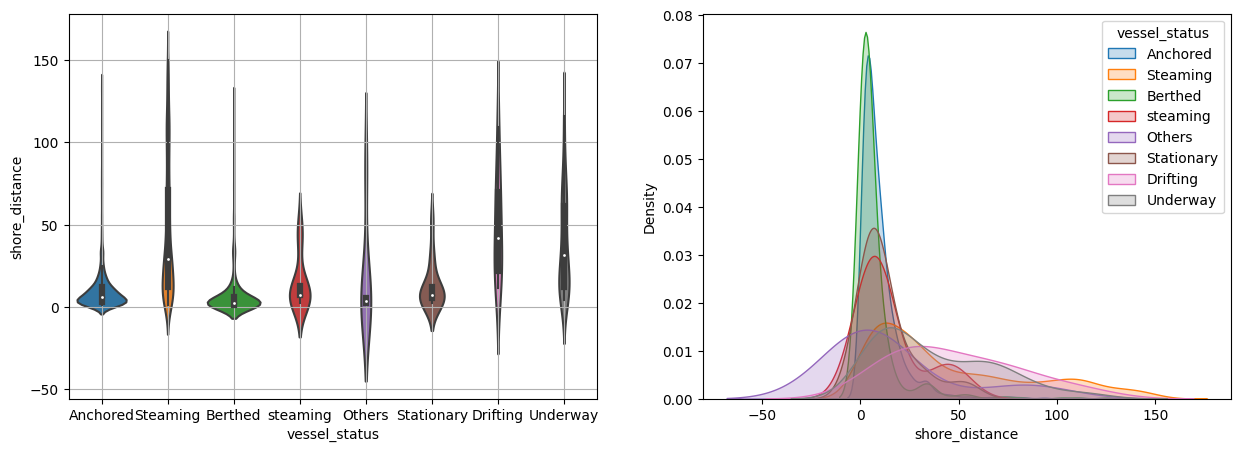

<module 'matplotlib.pyplot' from 'C:\\Users\\Alex\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\pyplot.py'>

In [12]:
others = ['Moored', 'Bunkering operations', 'Fishing', 'Grounded', 'Towed']
str_pirate_attacks = pirate_attacks.copy()
str_pirate_attacks= str_pirate_attacks[(str_pirate_attacks["shore_distance"]<=150) & (str_pirate_attacks["shore_distance"]>=1)].copy()
str_pirate_attacks = str_pirate_attacks[["shore_distance", 'vessel_status']].copy()
str_pirate_attacks = str_pirate_attacks.dropna()
str_pirate_attacks['vessel_status'] = str_pirate_attacks['vessel_status'].apply(lambda x: "Others" if x in others else x)
compare_variables(str_pirate_attacks, slice_values = ["shore_distance"], groupby='vessel_status', title = "", order = [])


In [13]:
str_pirate_attacks = pirate_attacks.copy()
str_pirate_attacks = str_pirate_attacks[["shore_distance", 'vessel_status']].copy()
str_pirate_attacks = str_pirate_attacks.dropna()

data_stats = str_pirate_attacks.groupby('vessel_status')["shore_distance"].describe().sort_values(by = "count", ascending = False)
data_stats["prob"] = data_stats["count"] * 100 / data_stats["count"].sum() 
data_stats["cum prob"] = np.cumsum(data_stats["count"]) * 100 / data_stats["count"].sum() 
display(data_stats)

count        mean         std        min        25%  \
vessel_status                                                                
Anchored              3262.0   11.003329   25.692483   0.039189   2.234518   
Steaming              2587.0  120.455445  189.355425   0.080958  14.718090   
Berthed                653.0    7.121408   24.904616   0.057301   0.906557   
Underway                56.0   45.347089   54.572107   0.938259  12.018877   
Stationary              14.0   12.968905   14.161565   2.437496   5.544718   
steaming                11.0   51.292302  122.578096   2.332013   7.032985   
Drifting                10.0   48.385703   31.697101  11.616214  21.664419   
Moored                   2.0    1.649886    0.685048   1.165484   1.407685   
Bunkering operations     1.0   84.035114         NaN  84.035114  84.035114   
Fishing                  1.0    2.519846         NaN   2.519846   2.519846   
Grounded                 1.0    5.870991         NaN   5.870991   5.870991   
Towed                    1.0    5.094829         NaN   5.094829   5.094829   

                            50%         75%          max       prob  \
vessel_status                                                         
Anchored               5.230245   11.060778   385.831709  49.431732   
Steaming              43.013050  115.712220  1024.029180  39.202910   
Berthed                1.718181    4.407542   318.902064   9.895439   
Underway              32.009997   62.540153   348.781333   0.848613   
Stationary             7.412294   12.010329    52.361966   0.212153   
steaming               7.627795   27.256380   417.952852   0.166692   
Drifting              42.199771   69.764651   109.446459   0.151538   
Moored                 1.649886    1.892087     2.134288   0.030308   
Bunkering operations  84.035114   84.035114    84.035114   0.015154   
Fishing                2.519846    2.519846     2.519846   0.015154   
Grounded               5.870991    5.870991     5.870991   0.015154   
Towed                  5.094829    5.094829     5.094829   0.015154   

                        cum prob  
vessel_status                     
Anchored               49.431732  
Steaming               88.634642  
Berthed                98.530080  
Underway               99.378694  
Stationary             99.590847  
steaming               99.757539  
Drifting               99.909077  
Moored                 99.939385  
Bunkering operations   99.954539  
Fishing                99.969692  
Grounded               99.984846  
Towed                 100.000000

11 Nearest Countries with largest number of cases:


nearest_country  counts       prob   cum prob
44              IDN    1939  25.880940  25.880940
70              NGA     559   7.461292  33.342232
101             YEM     546   7.287774  40.630005
68              MYS     529   7.060865  47.690870
6               BGD     470   6.273358  53.964229
45              IND     386   5.152162  59.116391
76              PHL     227   3.029899  62.146289
87              SOM     224   2.989856  65.136145
100             VNM     204   2.722904  67.859050
12              CHN     154   2.055526  69.914576
9               BRA     153   2.042178  71.956754

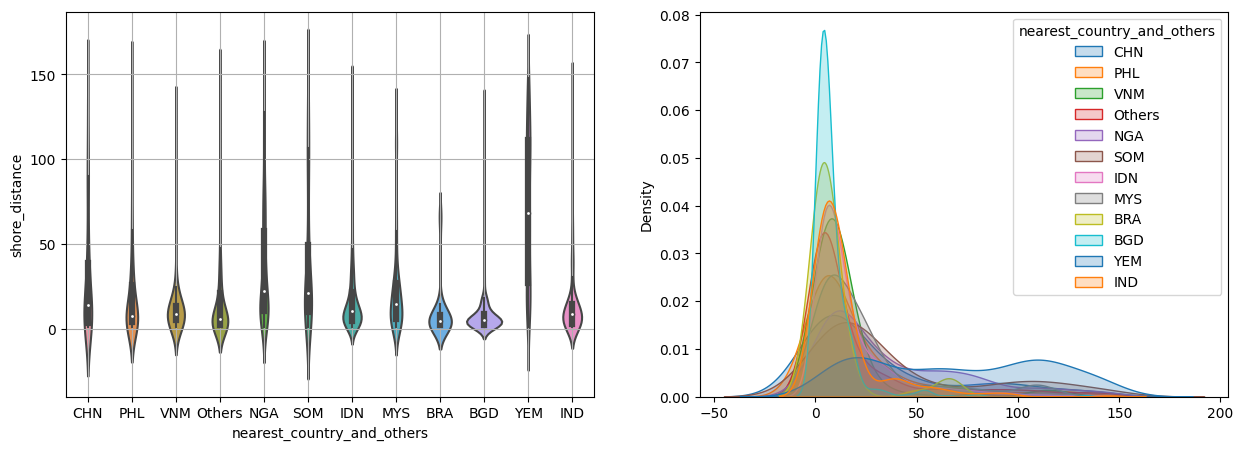

<module 'matplotlib.pyplot' from 'C:\\Users\\Alex\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\pyplot.py'>

In [14]:
pirate_attacks["counts"] = 1

nearest_countries = pirate_attacks.groupby(["nearest_country"]).agg({"counts": sum}).reset_index().sort_values(by = "counts", ascending = False)
nearest_countries["prob"] = nearest_countries["counts"] * 100 / nearest_countries["counts"].sum() 
nearest_countries["cum prob"] = np.cumsum(nearest_countries["counts"]) * 100 / nearest_countries["counts"].sum() 

print("11 Nearest Countries with largest number of cases:")
display(nearest_countries.head(11))

selected_nearest_countries = nearest_countries["nearest_country"].head(11).unique()

str_pirate_attacks = pirate_attacks.copy()
str_pirate_attacks= str_pirate_attacks[(str_pirate_attacks["shore_distance"]<=150) & (str_pirate_attacks["shore_distance"]>=1)].copy()

str_pirate_attacks["nearest_country_and_others"] = str_pirate_attacks["nearest_country"].apply(lambda x: x if x in selected_nearest_countries else "Others")
compare_variables(str_pirate_attacks, slice_values = ["shore_distance"], groupby="nearest_country_and_others", title = "", order = [])



11 EZZ Countries with largest number of cases:


eez_country  counts       prob   cum prob
42          IDN    1982  27.466741  27.466741
68          NGA     557   7.718958  35.185698
66          MYS     476   6.596452  41.782151
7           BGD     469   6.499446  48.281596
100         YEM     468   6.485588  54.767184
43          IND     338   4.684035  59.451220
74          PHL     229   3.173503  62.624723
99          VNM     199   2.757761  65.382483
86          SOM     163   2.258869  67.641353
10          BRA     153   2.120288  69.761641
12          CHN     144   1.995565  71.757206

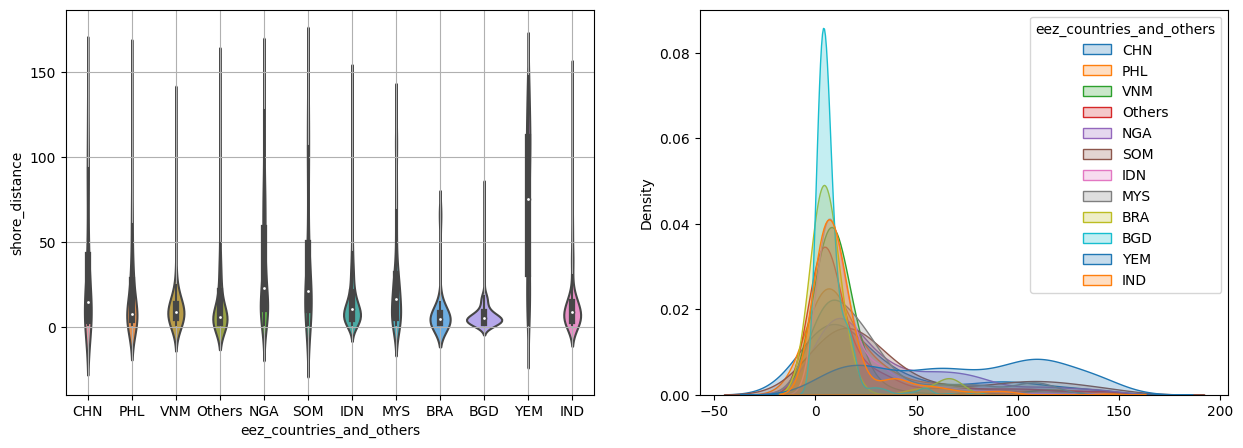

<module 'matplotlib.pyplot' from 'C:\\Users\\Alex\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\pyplot.py'>

In [15]:
eez_countries = pirate_attacks.groupby(["eez_country"]).agg({"counts": sum}).reset_index().sort_values(by = "counts", ascending = False)
eez_countries["prob"] = eez_countries["counts"] * 100 / eez_countries["counts"].sum() 
eez_countries["cum prob"] = np.cumsum(eez_countries["counts"]) * 100 / eez_countries["counts"].sum() 

print("11 EZZ Countries with largest number of cases:")
display(eez_countries.head(11))

selected_eez_countries = eez_countries["eez_country"].head(11).unique()

str_pirate_attacks = pirate_attacks.copy()
str_pirate_attacks= str_pirate_attacks[(str_pirate_attacks["shore_distance"]<=150) & (str_pirate_attacks["shore_distance"]>=1)].copy()

str_pirate_attacks["eez_countries_and_others"] = str_pirate_attacks["eez_country"].apply(lambda x: x if x in selected_eez_countries else "Others")
compare_variables(str_pirate_attacks, slice_values = ["shore_distance"], groupby="eez_countries_and_others", title = "", order = [])


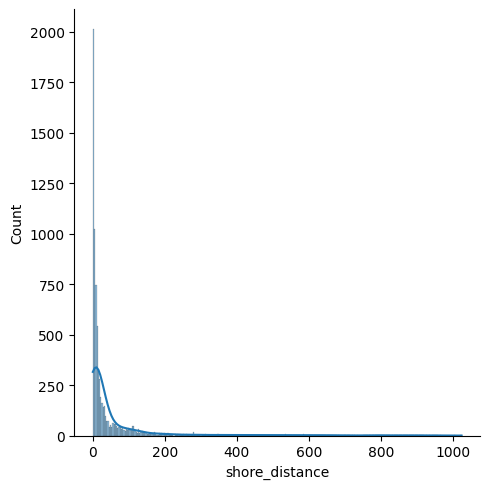

In [16]:
import seaborn as sns
sns.displot(pirate_attacks, x="shore_distance", kde=True)

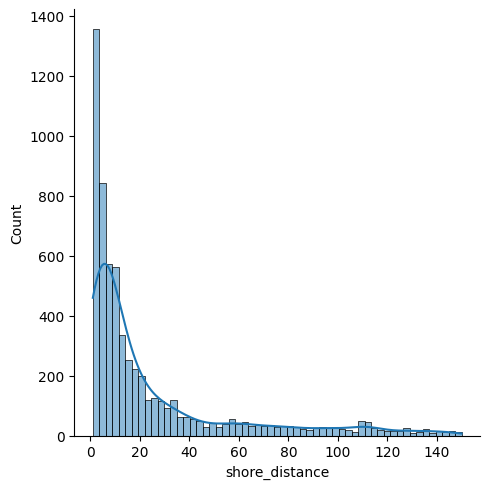

In [17]:
constrained_pirate_attacks = pirate_attacks[(pirate_attacks["shore_distance"]<=150) & (pirate_attacks["shore_distance"]>=1)].copy()

sns.displot(constrained_pirate_attacks, x="shore_distance", kde=True)

In order to install **shapely** see https://gis.stackexchange.com/questions/62925/shapely-not-installing-correctly 

Perform the following command in terminal:

**conda install shapely**

Perform the following command in terminal to install **geopandas**:

**conda install geopandas**

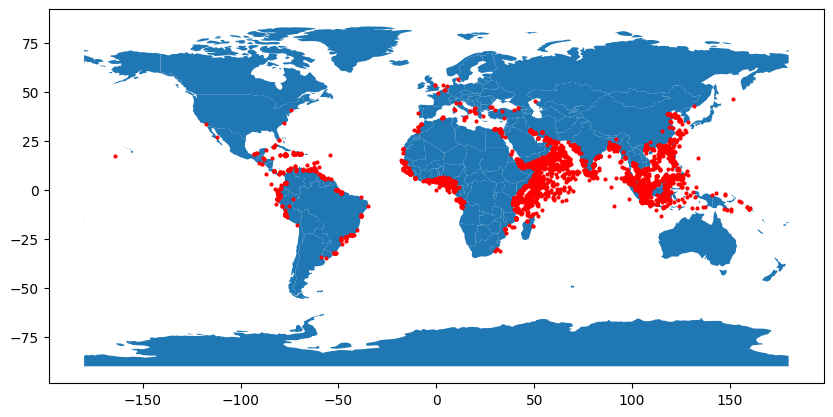

In [18]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

df = pirate_attacks.copy()

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='.', color='red', markersize=15)

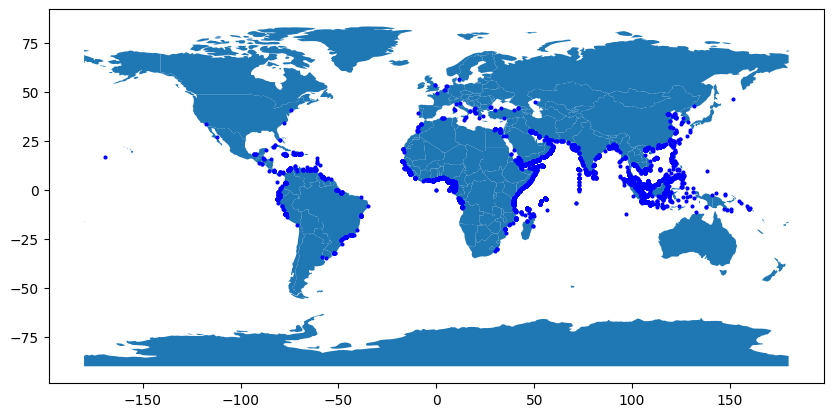

In [19]:
df = pirate_attacks.copy()

geometry = [Point(xy) for xy in zip(df['shore_longitude'], df['shore_latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='.', color='blue', markersize=15);

**country_indicators.csv**
-	Country [Key] - The country in ISO3 country code format.
-	Corruption Index - Corruption Perceptions Index.
-	Homicide Rate - Total Intentional Homicides per 100,000 people.
-	GPD - Gross Domestic Product (US Dollars).
-	Total Fisheries Per Ton - Total Fisheries Production (metric tons).
-	Total Military - Total Number of Armed Forces personnel.
-	Population - Country Population.
-	Unemployment Rate - Percentage of the Country Unemployed.
-	Total GR - Total Government Revenue. An indication of how well the country collects taxes.
-	Industry - Industrial contribution to total GDP.


In [20]:
name = "country_indicators.csv"
country_indicators = pd.read_csv(name)
display(country_indicators["country"].unique())
country_indicators


array(['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM',
       'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD',
       'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA',
       'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHI', 'CHL',
       'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI',
       'CUB', 'CUW', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK',
       'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'FIN',
       'FJI', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR', 'GEO', 'GHA', 'GIB',
       'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL', 'GTM', 'GUM',
       'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IMN', 'IND',
       'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN',
       'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAO',
       'LBN', 'LBR', 'LBY', 'LCA', 'LIE', 'LKA', 'LSO', 'LTU', 'LUX',
       'LVA', 'MAC', 'MAF', 'MAR', 'MCO', 'MDA', 'MDG', 'MDV', 'MEX',
       'MHL', 'MKD',

country    year  corruption_index  homicide_rate           GDP  \
0        ABW  1993.0               NaN            NaN  14936.827219   
1        ABW  1994.0               NaN            NaN  16241.046521   
2        ABW  1995.0               NaN       7.469748  16439.356361   
3        ABW  1996.0               NaN            NaN  16586.068436   
4        ABW  1997.0               NaN            NaN  17927.749635   
...      ...     ...               ...            ...           ...   
5894     ZWE  2015.0              21.0            NaN   1445.071062   
5895     ZWE  2016.0              22.0            NaN   1464.583529   
5896     ZWE  2017.0              22.0            NaN   1548.170056   
5897     ZWE  2018.0              22.0            NaN   1683.740577   
5898     ZWE  2019.0              24.0            NaN   1463.985910   

      total_fisheries_per_ton  total_military  population  unemployment_rate  \
0                       260.0             NaN     72504.0                NaN   
1                       260.0             NaN     76700.0                NaN   
2                       140.0             NaN     80324.0                NaN   
3                       160.0             NaN     83200.0                NaN   
4                       205.0             NaN     85451.0                NaN   
...                       ...             ...         ...                ...   
5894                  25500.0         50800.0  13814629.0              5.302   
5895                  25796.0         50800.0  14030390.0              5.253   
5896                      NaN         51000.0  14236745.0              5.168   
5897                      NaN             NaN  14439018.0              5.087   
5898                      NaN             NaN  14645468.0              4.954   

       totalgr  industryofgdp  
0          NaN            NaN  
1          NaN            NaN  
2          NaN       0.153986  
3     0.315830       0.149867  
4     0.279613       0.171327  
...        ...            ...  
5894  0.187196       0.223584  
5895  0.168317       0.221151  
5896  0.141045       0.214050  
5897  0.128309       0.206429  
5898       NaN            NaN  

[5899 rows x 11 columns]

In [21]:
indicators = {"corruption_index": np.median, "homicide_rate": np.median, "GDP": np.median, "total_fisheries_per_ton": np.median, "total_military": np.median, "population": np.median, "unemployment_rate": np.median, "totalgr": np.median, "industryofgdp": np.median}
median_country_indicators = country_indicators.groupby("country").agg(indicators).reset_index()
median_country_indicators.head()

country  corruption_index  homicide_rate           GDP  \
0     ABW               NaN       4.032891  23300.039558   
1     AFG              8.00       6.401246    513.139184   
2     AGO              2.20       4.601430   2599.566464   
3     ALB              3.35       4.289124   2972.743265   
4     AND               NaN       0.000000  37969.174991   

   total_fisheries_per_ton  total_military  population  unemployment_rate  \
0                   161.00             NaN    100834.0                NaN   
1                  1600.00        314100.0  26433049.0          11.472000   
2                247329.00        117000.0  20149901.0           3.842000   
3                  6295.75         21500.0   2992547.0          16.478001   
4                      NaN             NaN     77006.0                NaN   

    totalgr  industryofgdp  
0  0.263586       0.167927  
1  0.218874       0.222038  
2  0.371145       0.560512  
3  0.259612       0.223411  
4       NaN            NaN

In [22]:
indicators_pirate_attacks = median_country_indicators.merge(pirate_attacks, left_on = "country", right_on = "eez_country", how = "left")
indicators_pirate_attacks["counts"] = indicators_pirate_attacks["counts"].fillna(0)
indicators_pirate_attacks

country  corruption_index  homicide_rate           GDP  \
0        ABW               NaN       4.032891  23300.039558   
1        AFG              8.00       6.401246    513.139184   
2        AGO              2.20       4.601430   2599.566464   
3        AGO              2.20       4.601430   2599.566464   
4        AGO              2.20       4.601430   2599.566464   
...      ...               ...            ...           ...   
7295     ZAF              5.05      38.350000   5383.656543   
7296     ZAF              5.05      38.350000   5383.656543   
7297     ZAF              5.05      38.350000   5383.656543   
7298     ZMB              3.20       6.144467   1047.919187   
7299     ZWE              2.90      11.229917    623.209967   

      total_fisheries_per_ton  total_military  population  unemployment_rate  \
0                       161.0             NaN    100834.0                NaN   
1                      1600.0        314100.0  26433049.0             11.472   
2                    247329.0        117000.0  20149901.0              3.842   
3                    247329.0        117000.0  20149901.0              3.842   
4                    247329.0        117000.0  20149901.0              3.842   
...                       ...             ...         ...                ...   
7295                 623268.5         77153.0  48489459.0             28.489   
7296                 623268.5         77153.0  48489459.0             28.489   
7297                 623268.5         77153.0  48489459.0             28.489   
7298                  74342.0         16500.0  12173514.0             12.510   
7299                  15903.0         51000.0  12155491.0              5.217   

       totalgr  industryofgdp  ... eez_country shore_distance  \
0     0.263586       0.167927  ...         NaN            NaN   
1     0.218874       0.222038  ...         NaN            NaN   
2     0.371145       0.560512  ...         AGO       0.509216   
3     0.371145       0.560512  ...         AGO       0.509216   
4     0.371145       0.560512  ...         AGO      86.692044   
...        ...            ...  ...         ...            ...   
7295  0.333395       0.273813  ...         ZAF       7.180394   
7296  0.333395       0.273813  ...         ZAF     171.752526   
7297  0.333395       0.273813  ...         ZAF       1.210743   
7298  0.204210       0.322389  ...         NaN            NaN   
7299  0.187196       0.233605  ...         NaN            NaN   

      shore_longitude  shore_latitude  \
0                 NaN             NaN   
1                 NaN             NaN   
2           13.245372       -8.800063   
3           13.245372       -8.800063   
4           13.184337       -5.856215   
...               ...             ...   
7295        30.095063      -31.178643   
7296        30.786469      -30.237481   
7297        31.050466      -29.885186   
7298              NaN             NaN   
7299              NaN             NaN   

                                     attack_description vessel_name  \
0                                                   NaN         NaN   
1                                                   NaN         NaN   
2                                                   NaN   Mv Bodrog   
3                                                   NaN         NaN   
4                                                   NaN    Mv Tilly   
...                                                 ...         ...   
7295                                                NaN  Kota Manis   
7296                                                NaN     Linares   
7297  23.05.2016: 2000 LT: Posn: Island View Berth N...         NaN   
7298                                                NaN         NaN   
7299                                                NaN         NaN   

     vessel_type vessel_status    data_source  counts  
0            NaN           NaN            NaN     0.0  
1            NaN           NaN            NaN   

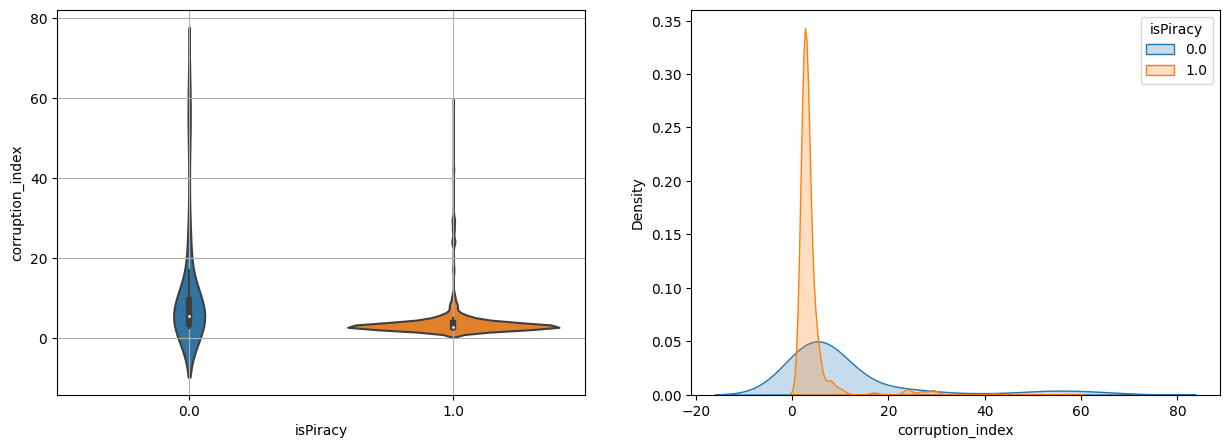

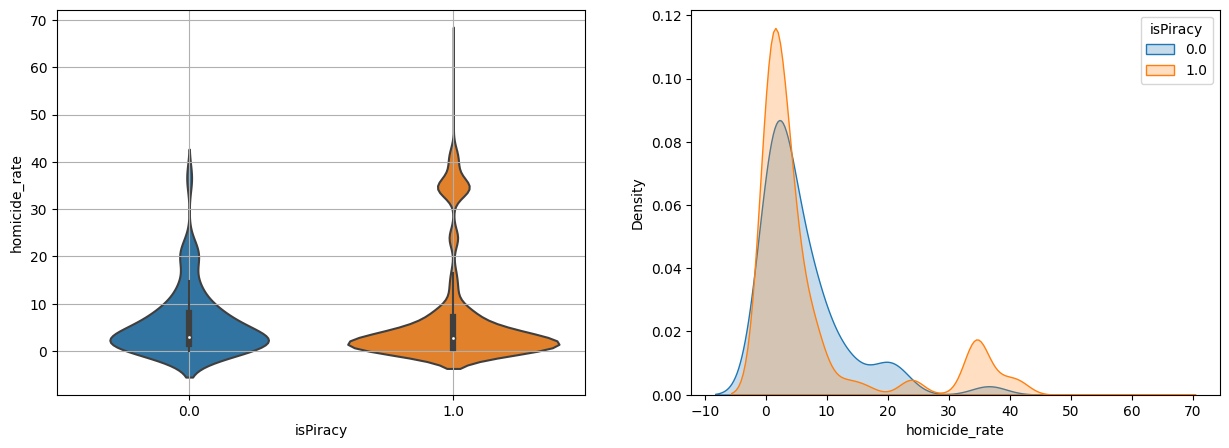

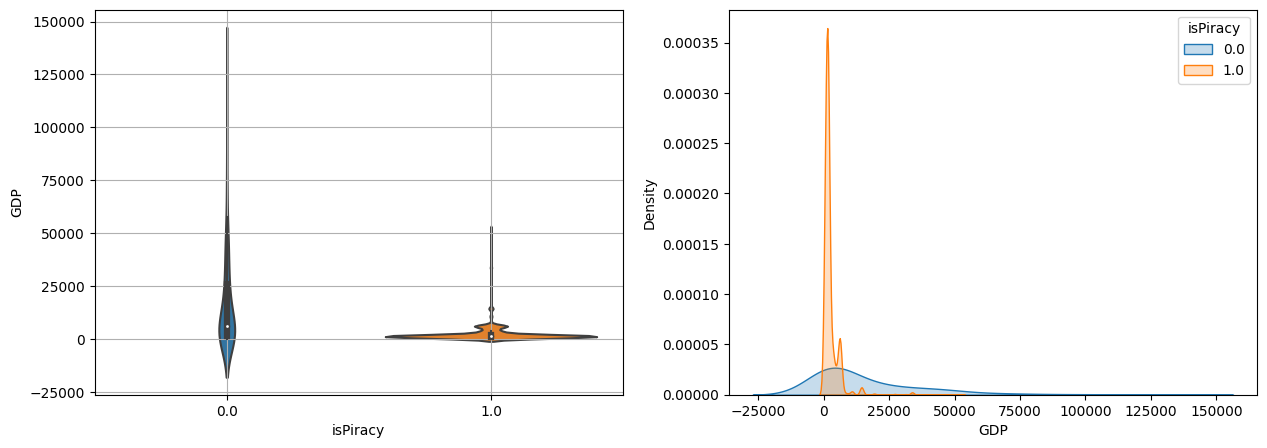

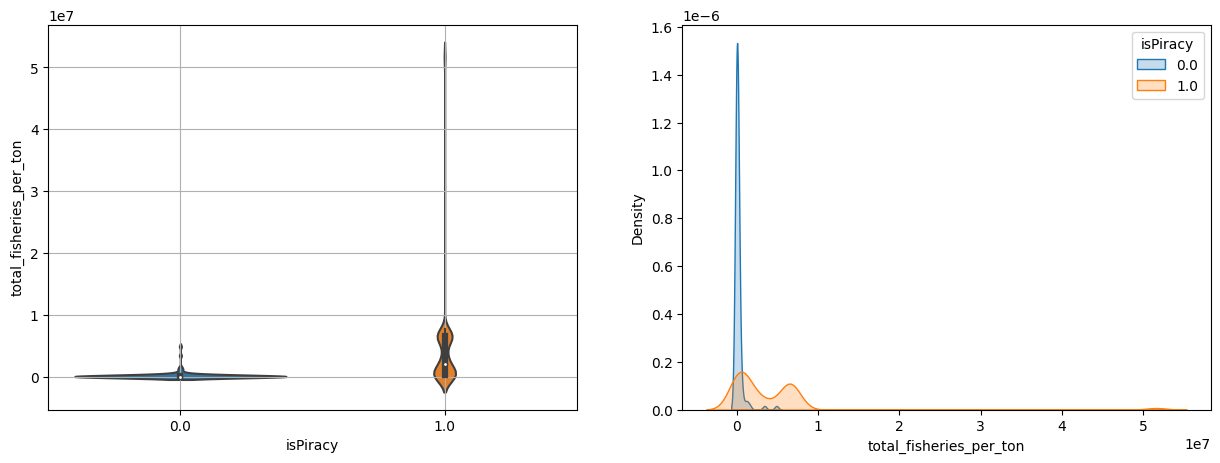

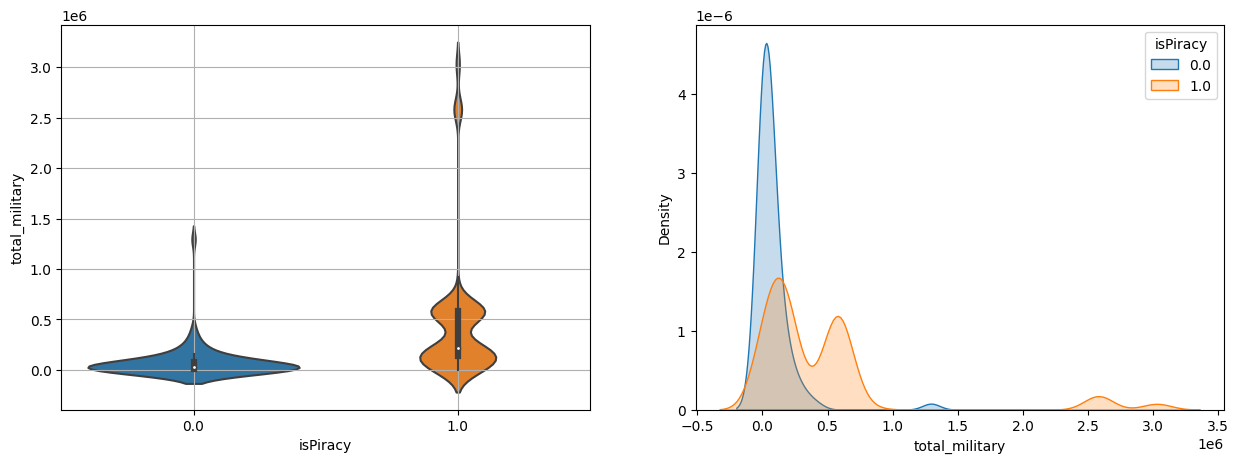

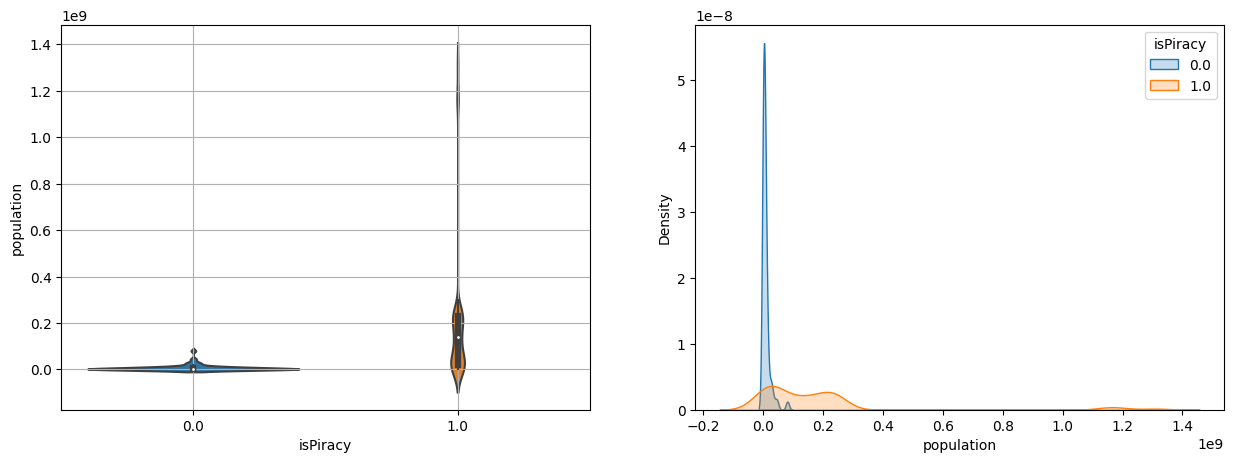

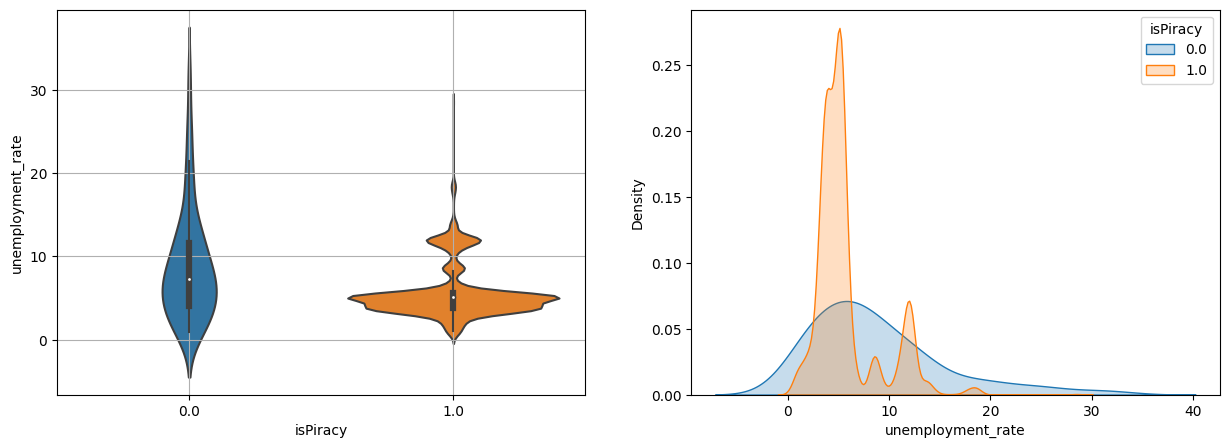

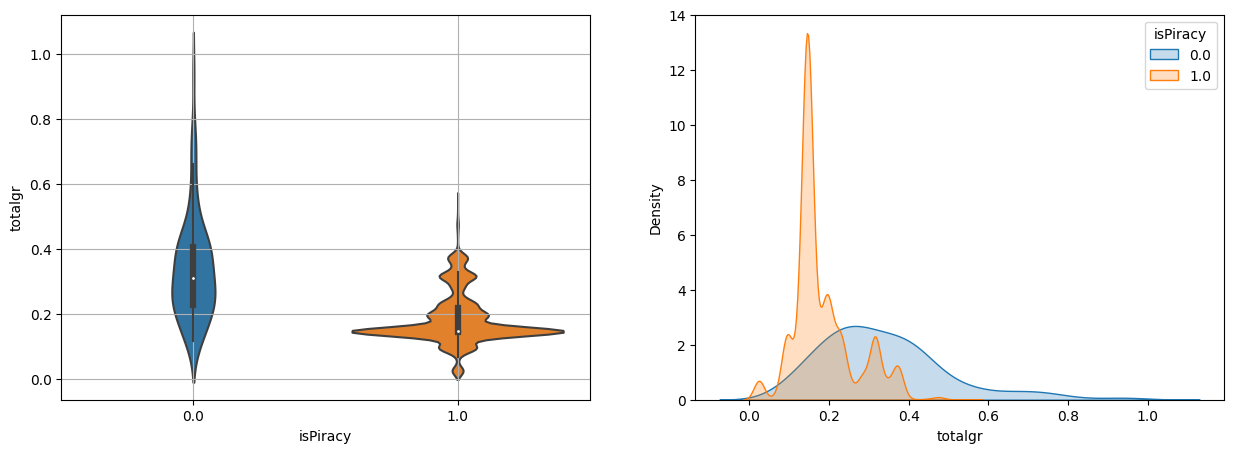

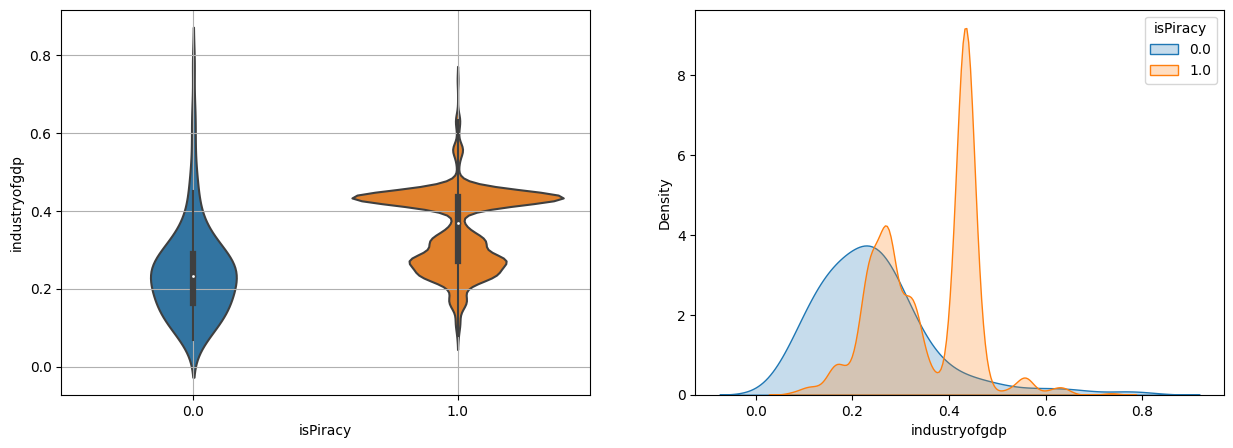

<module 'matplotlib.pyplot' from 'C:\\Users\\Alex\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\pyplot.py'>

In [34]:
indicators_cols = list(indicators.keys())
indicators_pirate_attacks["isPiracy"] = indicators_pirate_attacks["counts"].copy()
compare_variables(indicators_pirate_attacks, slice_values = indicators_cols, groupby="isPiracy", title = "", order = [])


In [24]:
pd.set_option('display.max_rows', 72)
indicators_pirate_attacks[["isPiracy"] + indicators_cols].groupby("isPiracy").describe().T

isPiracy                                0.0           1.0
corruption_index        count  8.900000e+01  7.180000e+03
                        mean   1.135388e+01  4.196662e+00
                        std    1.492354e+01  5.088099e+00
                        min    2.300000e+00  1.900000e+00
                        25%    3.400000e+00  2.685000e+00
                        50%    5.350000e+00  2.700000e+00
                        75%    9.300000e+00  3.600000e+00
                        max    6.550000e+01  5.800000e+01
homicide_rate           count  1.070000e+02  6.649000e+03
                        mean   5.965866e+00  7.516844e+00
                        std    7.026579e+00  1.151447e+01
                        min    0.000000e+00  2.675182e-01
                        25%    1.448213e+00  5.826651e-01
                        50%    3.018992e+00  2.702347e+00
                        75%    7.992577e+00  7.082978e+00
                        max    3.716856e+01  6.453468e+01
GDP                     count  1.140000e+02  7.018000e+03
                        mean   1.731212e+04  2.547640e+03
                        std    2.345658e+04  3.964317e+03
                        min    1.673765e+02  2.863305e+02
                        25%    1.507541e+03  8.576201e+02
                        50%    6.102321e+03  1.589801e+03
                        75%    2.594760e+04  2.073436e+03
                        max    1.291192e+05  5.202700e+04
total_fisheries_per_ton count  1.140000e+02  7.181000e+03
                        mean   1.650371e+05  3.913209e+06
                        std    5.929556e+05  7.370366e+06
                        min    1.000000e+00  1.041000e+03
                        25%    2.438125e+03  2.473290e+05
                        50%    1.103219e+04  2.102215e+06
                        75%    4.458753e+04  6.517730e+06
                        max    4.874622e+06  5.160000e+07
total_military          count  7.900000e+01  7.171000e+03
                        mean   7.435411e+04  4.581878e+05
                        std    1.604524e+05  6.507234e+05
                        min    1.300000e+02  6.500000e+02
                        25%    1.075000e+04  1.336000e+05
                        50%    2.562000e+04  2.209500e+05
                        75%    7.400000e+04  5.820000e+05
                        max    1.295000e+06  3.030000e+06
population              count  1.190000e+02  7.181000e+03
                        mean   7.254806e+06  1.837616e+08
                        std    1.322268e+07  2.892349e+08
                        min    1.012000e+04  1.800800e+04
                        25%    1.494440e+05  2.108011e+07
                        50%    2.504019e+06  1.409212e+08
                        75%    8.088024e+06  2.293183e+08
                        max    8.210024e+07  1.311020e+09
unemployment_rate       count  9.100000e+01  7.141000e+03
                        mean   8.783533e+00  5.723817e+00
                        std    6.601083e+00  3.187666e+00
                        min    8.700000e-01  6.300000e-01
                        25%    4.031500e+00  3.770000e+00
                        50%    7.344000e+00  5.153000e+00
                        75%    1.162800e+01  5.631000e+00
                        max    3.220000e+01  2.848900e+01
totalgr                 count  9.000000e+01  7.055000e+03
                        mean   3.355034e-01  1.833210e-01
                        std    1.576547e-01  7.857331e-02
                        min    1.168052e-01  2.397489e-02
                        25%    2.276458e-01  1.433343e-01
                        50%    3.081389e-01  1.458010e-01
                        75%    4.051297e-01  2.178834e-01
                        max    9.384615e-01  5.457943e-01
industryofgdp           count  1.070000e+02  7.011000e+03
                        mean   2.438754e-01  3.533369e-01
                        std    1.216062e-01  1.013308e-01
                        min    6.822262e-02  7.828153e-0

In [25]:
False_indicators_pirate_attacks = indicators_pirate_attacks[indicators_pirate_attacks["isPiracy"] == 0].copy()
True_indicators_pirate_attacks  = indicators_pirate_attacks[indicators_pirate_attacks["isPiracy"] == 1].copy()

final = []
for col in indicators_cols:
    rvs1 = False_indicators_pirate_attacks[col].dropna()
    rvs2 = True_indicators_pirate_attacks[ col].dropna()
    statistic, pvalue = stats.ttest_ind(rvs1, rvs2)
    
    elem = {"indicator": col, "False mean": np.mean(rvs1), "True mean": np.mean(rvs2), "False std": np.std(rvs1), "True std": np.std(rvs2), "statistic": statistic, "pvalue": pvalue, "decision": "Significan Difference" if pvalue <= 0.05 else "Not Significan Difference"}
    final.append(elem)
    
final_df = pd.DataFrame(final)
final_df

indicator    False mean     True mean     False std  \
0         corruption_index  1.135388e+01  4.196662e+00  1.483947e+01   
1            homicide_rate  5.965866e+00  7.516844e+00  6.993667e+00   
2                      GDP  1.731212e+04  2.547640e+03  2.335348e+04   
3  total_fisheries_per_ton  1.650371e+05  3.913209e+06  5.903492e+05   
4           total_military  7.435411e+04  4.581878e+05  1.594336e+05   
5               population  7.254806e+06  1.837616e+08  1.316701e+07   
6        unemployment_rate  8.783533e+00  5.723817e+00  6.564713e+00   
7                  totalgr  3.355034e-01  1.833210e-01  1.567764e-01   
8            industryofgdp  2.438754e-01  3.533369e-01  1.210366e-01   

       True std  statistic         pvalue                   decision  
0  5.087745e+00  12.620720   3.878841e-36      Significan Difference  
1  1.151360e+01  -1.389109   1.648454e-01  Not Significan Difference  
2  3.964035e+03  31.796745  1.317089e-207      Significan Difference  
3  7.369853e+06  -5.429146   5.844771e-08      Significan Difference  
4  6.506780e+05  -5.240672   1.645057e-07      Significan Difference  
5  2.892148e+08  -6.656523   3.007058e-11      Significan Difference  
6  3.187443e+00   8.918009   5.930880e-19      Significan Difference  
7  7.856774e-02  17.923451   2.638178e-70      Significan Difference  
8  1.013236e-01 -11.053588   3.567704e-28      Significan Difference

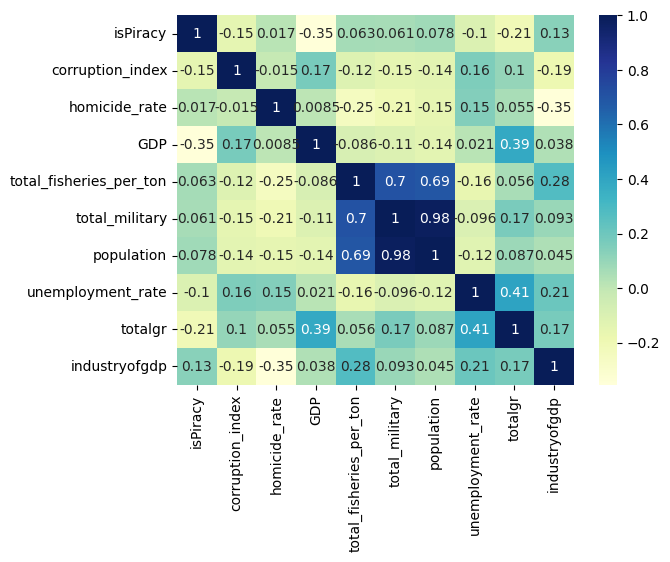

In [26]:
dataplot = sns.heatmap(indicators_pirate_attacks[["isPiracy"] + indicators_cols].corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

**country_codes.csv**
-	Country [Key] - The country in ISO3 country code format.
-	Region - The region the country is in.
-	Country Name - The English country name.


In [41]:
name = "country_codes.csv"
country_codes_df = pd.read_csv(name)
country_codes_df["country_name"] = country_codes_df["country_name"].apply(lambda x: x.upper())
country_codes_df

country                      region  country_name
0       ABW   Latin America & Caribbean         ARUBA
1       AFG                  South Asia   AFGHANISTAN
2       AGO          Sub-Saharan Africa        ANGOLA
3       ALB       Europe & Central Asia       ALBANIA
4       AND       Europe & Central Asia       ANDORRA
..      ...                         ...           ...
212     XKX       Europe & Central Asia        KOSOVO
213     YEM  Middle East & North Africa   YEMEN, REP.
214     ZAF          Sub-Saharan Africa  SOUTH AFRICA
215     ZMB          Sub-Saharan Africa        ZAMBIA
216     ZWE          Sub-Saharan Africa      ZIMBABWE

[217 rows x 3 columns]

**shipping_lanes.bin** is a binary file containing long list of integers (uint32, encoded on Windows machine). These integers are repeating triplets of the form: 

(**latitude_index**, **longitude_index**, **shipping_lane_index**)

To convert the latitude and longitude indices into an actual decimal latitude/longitude:
- **latitude** = 90.0 - **latitude_index**  × 0.13053608405076406
- **longitude** = -180.0 + **longitude_index** × 0.13053608405076406

The **shipping_lane_index** is a measure of how busy the seas are at that lat/long point. Not all grid points are represented. If a grid square isn’t represented in the data, you can assume that the shipping_lane_index is 0 at that square.


In [28]:
import struct
fin = open("shipping_lanes.bin", "rb")
print(struct.unpack('i', fin.read(4)))
print(struct.unpack('i', fin.read(4)))
print(struct.unpack('i', fin.read(4)))

(6,)
(578,)
(9,)


In [32]:
import numpy as np

f = open("shipping_lanes.bin", "rb")
data = np.fromfile(f, dtype=np.uint32)
data = data.reshape(len(data)//3,3).astype(float)
shipping_lanes_df = pd.DataFrame({"latitude_index": data[:,0], "longitude_index": data[:,1], "shipping_lane_index": data[:,2]}) 

shipping_lanes_df["latitude" ] = shipping_lanes_df["latitude_index" ].apply(lambda x:  90.0  - x * 0.13053608405076406)
shipping_lanes_df["longitude"] = shipping_lanes_df["longitude_index"].apply(lambda x: -180.0  + x * 0.13053608405076406)
shipping_lanes_df.describe()

latitude_index  longitude_index  shipping_lane_index      latitude  \
count    1.588405e+06     1.588405e+06         1.588405e+06  1.588405e+06   
mean     6.429307e+02     1.310840e+03         3.960773e+02  6.074343e+00   
std      2.665608e+02     8.397231e+02         4.710657e+03  3.479580e+01   
min      6.000000e+00     0.000000e+00         1.000000e+00 -8.883444e+01   
25%      4.430000e+02     5.610000e+02         4.600000e+01 -2.082514e+01   
50%      6.520000e+02     1.219000e+03         1.230000e+02  4.890473e+00   
75%      8.490000e+02     2.047000e+03         4.280000e+02  3.217251e+01   
max      1.370000e+03     2.756000e+03         9.928520e+05  8.921678e+01   

          longitude  
count  1.588405e+06  
mean  -8.888129e+00  
std    1.096142e+02  
min   -1.800000e+02  
25%   -1.067693e+02  
50%   -2.087651e+01  
75%    8.720736e+01  
max    1.797574e+02

C:\Users\Alex\anaconda3\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


latitude   longitude  shipping_lane_index                    geometry
16703  78.251752   13.323940                713.0   POINT (13.32394 78.25175)
16704  78.251752   13.454477                542.0   POINT (13.45448 78.25175)
17152  78.121216   13.193404                442.0   POINT (13.19340 78.12122)
17153  78.121216   13.323940                489.0   POINT (13.32394 78.12122)
18612  77.729608  106.787777                430.0  POINT (106.78778 77.72961)

Text(0.5, 1.0, 'Ship Routes')

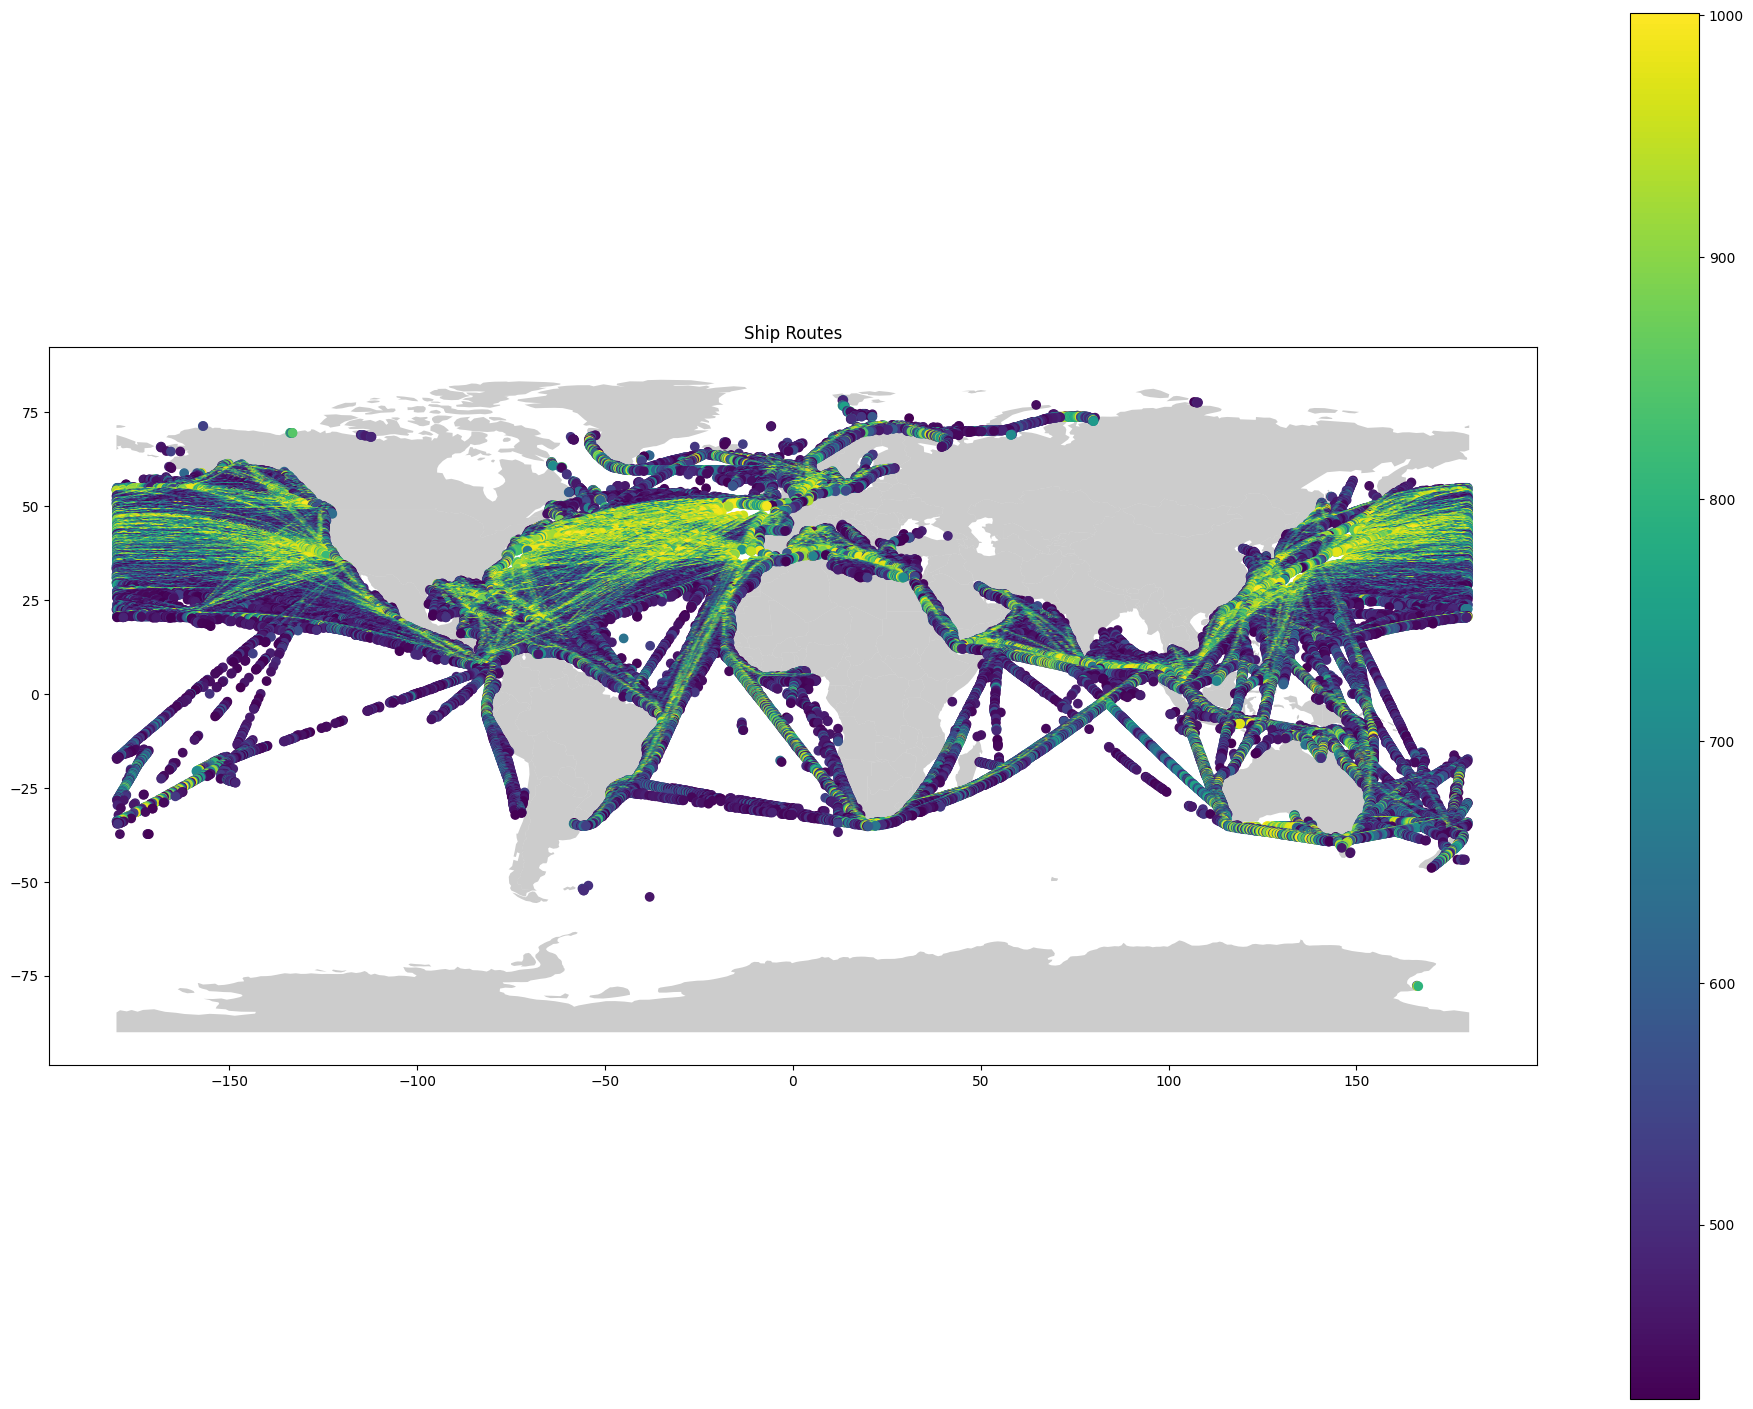

In [37]:
Q25_value = Q25(shipping_lanes_df["shipping_lane_index"])
Q75_value = Q75(shipping_lanes_df["shipping_lane_index"])
IQR = Q75_value - Q25_value
Upper_threshold = Q75_value + 1.5 * IQR

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

shipping_lanes_df_100 = shipping_lanes_df[(shipping_lanes_df["shipping_lane_index"] >= Q75_value) & (shipping_lanes_df["shipping_lane_index"] <= Upper_threshold)].copy()

geometry = gpd.points_from_xy(shipping_lanes_df_100["longitude"], shipping_lanes_df_100["latitude"])
geo_df = gpd.GeoDataFrame(
    shipping_lanes_df_100[["latitude", "longitude", "shipping_lane_index"]], geometry=geometry
)

display(geo_df.head())


fig, ax = plt.subplots(figsize=(24, 18))
world.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot("shipping_lane_index", ax = ax, legend=True)
plt.title("Ship Routes")

In [35]:
name = "US-Bases-Abroad.xlsx"
US_Bases_Abroad = pd.read_excel(name, header = 17, skiprows = [1015], sheet_name = "2019")
US_Bases_Abroad.drop_duplicates(subset = "Country/Territory Name", inplace = True)
US_Bases_Abroad.dropna(subset = ["Latitude", "Longitude"], inplace = True)

rename_coutries = {'CENTRAL AFRICAN REP.': 'CENTRAL AFRICAN REPUBLIC',
'CONGO, DEMOCRATIC REPUBLIC OF THE': 'CONGO, DEM. REP.',
'CURAÇAO (NETHERLANDS ANTILLES)': 'CURAÇAO',
'EGYPT': 'EGYPT, ARAB REP.',
'GREENLAND (Denmark)': 'GREENLAND',
'HONG KONG (CHINA)': 'HONG KONG SAR, CHINA',
'NORTHERN MARIANA IS': 'NORTHERN MARIANA ISLANDS'}

US_Bases_Abroad["Country/Territory Name"] = US_Bases_Abroad["Country/Territory Name"].apply(lambda x: rename_coutries[x] if x in rename_coutries else x)

US_Bases_Abroad

Country/Territory Name  \
0               AFGHANISTAN   
13           AMERICAN SAMOA   
17               ANTARCTICA   
18      ANTIGUA AND BARBUDA   
19                ARGENTINA   
...                     ...   
966    UNITED ARAB EMIRATES   
994                 URUGUAY   
999          VIRGIN ISLANDS   
1005            WAKE ISLAND   
1012                 ZAMBIA   

                                             Unnamed: 1   Latitude  \
0                                             Bagram AB  34.946222   
13                    TE O USARC Army Reserve Pago Pago   -14.1646   
17                                     McMurdo Station      -77.85   
18              Antigua Air Station, ST. Johns, Antigua    17.1367   
19                                  Trelew, Golfo Nuevo      -43.3   
...                                                 ...        ...   
966                                           Al Dhafra      24.24   
994                              14th Battalion, Toledo -34.740542   
999   NG Bethlehem Military Compound Army Guard St. ...       18.2   
1005                               Wake Island Airfield      19.18   
1012                              Lusaka? CSL agreement -15.416667   

       Longitude # Bases  # Lily Pads  Unconfirmed  # US Funded  \
0      69.264639        1         NaN          NaN          NaN   
13   -170.420200      NaN           1          NaN          NaN   
17    166.666667      NaN         NaN          NaN          NaN   
18    -61.792800      NaN         NaN          NaN          NaN   
19    -65.100000      NaN         NaN          1.0          NaN   
...          ...      ...         ...          ...          ...   
966    54.548333        1         NaN          NaN          NaN   
994   -56.096084      NaN         NaN          NaN          1.0   
999   -64.550000        1         NaN          NaN          NaN   
1005  166.380000      NaN           1          NaN          NaN   
1012   28.283333      NaN         NaN          NaN          NaN   

                                                  Notes Unnamed: 9  \
0     2014 agreement allows U.S. troops to remain at...        NaN   
13    Now a small base, the military has had a prese...        NaN   
17    NSF NOW RUNS: McMurdo Station hosts military p...        NaN   
18                                          CLOSED 7/15        NaN   
19    Omega VLF communications station (demolished 1...        NaN   
...                                                 ...        ...   
966   Major Middle East hub with Navy’s busiest over...        NaN   
994                                                GPOI        NaN   
999   Purchased from Denmark in 1917 to prevent Germ...        NaN   
1005  Claimed after 1898 Spanish-American War, now a...        NaN   
1012                                                NaN        NaN   

       Unnamed: 10                                          Source(s)  \
0     ? (550 max)   TomDispatch; https://militarybases.com/oversea...   
13             NaN                                                BSR   
17             NaN                                       News reports   
18             NaN                                                NaN   
19    Harkavy 2007                                                NaN   
...            ...                                                ...   
966            NaN  BSR2018=2; America Security Project 2018 = 3; ...   
994            NaN                                  USACE 14 Aug 2013   
999            NaN                                 BSR; MilCon FY2012   
1005           NaN                                                BSR   
1012           NaN  CRS 2011, 10; C. Johnson, Nemesis, 147-148; Co...   

                                            Unnamed: 12 Unnamed: 13  \
0     Camp Morehead, Forward Operating Base Fenty, T...         NaN   
13                                                  NaN         NaN   
17                                                  NaN

C:\Users\Alex\anaconda3\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


<AxesSubplot: >

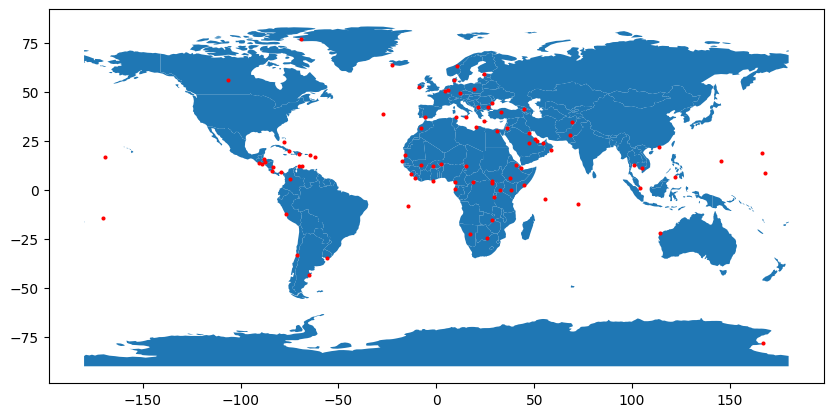

In [36]:
df = US_Bases_Abroad.copy()

geometry = gpd.points_from_xy(df["Longitude"], df["Latitude"])
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='.', color='red', markersize=15)

In [42]:
codes_US_Bases_Abroad = US_Bases_Abroad.merge(country_codes_df, left_on = ["Country/Territory Name"], right_on = ["country_name"])
print("US_Bases_Abroad: ", len(US_Bases_Abroad))
print("size codes_US_Bases_Abroad: ", len(codes_US_Bases_Abroad))
codes_US_Bases_Abroad.head()

US_Bases_Abroad:  91
size codes_US_Bases_Abroad:  85


Country/Territory Name                               Unnamed: 1   Latitude  \
0            AFGHANISTAN                                Bagram AB  34.946222   
1         AMERICAN SAMOA        TE O USARC Army Reserve Pago Pago   -14.1646   
2    ANTIGUA AND BARBUDA  Antigua Air Station, ST. Johns, Antigua    17.1367   
3              ARGENTINA                      Trelew, Golfo Nuevo      -43.3   
4                  ARUBA                                    Aruba   12.52111   

    Longitude # Bases  # Lily Pads  Unconfirmed  # US Funded  \
0   69.264639        1         NaN          NaN          NaN   
1 -170.420200      NaN           1          NaN          NaN   
2  -61.792800      NaN         NaN          NaN          NaN   
3  -65.100000      NaN         NaN          1.0          NaN   
4  -69.968338      NaN           1          NaN          NaN   

                                               Notes Unnamed: 9   Unnamed: 10  \
0  2014 agreement allows U.S. troops to remain at...        NaN  ? (550 max)    
1  Now a small base, the military has had a prese...        NaN           NaN   
2                                        CLOSED 7/15        NaN           NaN   
3  Omega VLF communications station (demolished 1...        NaN  Harkavy 2007   
4  Small "cooperative security location" in Aruba...        NaN           NaN   

                                           Source(s)  \
0  TomDispatch; https://militarybases.com/oversea...   
1                                                BSR   
2                                                NaN   
3                                                NaN   
4                                                BSR   

                                         Unnamed: 12 Unnamed: 13  Unnamed: 14  \
0  Camp Morehead, Forward Operating Base Fenty, T...         NaN          NaN   
1                                                NaN         NaN          NaN   
2                                                NaN         NaN          NaN   
3                                                NaN         NaN          NaN   
4                                                NaN         NaN          NaN   

   Unnamed: 15 country                     region         country_name  
0          NaN     AFG                 South Asia          AFGHANISTAN  
1          NaN     ASM        East Asia & Pacific       AMERICAN SAMOA  
2          NaN     ATG  Latin America & Caribbean  ANTIGUA AND BARBUDA  
3          NaN     ARG  Latin America & Caribbean            ARGENTINA  
4          NaN     ABW  Latin America & Caribbean                ARUBA

In [44]:
codes_US_Bases_Abroad["isNato"] = 1
US_Bases_indicators_pirate_attacks = indicators_pirate_attacks.merge(codes_US_Bases_Abroad, on = ["country"], how = "left")
US_Bases_indicators_pirate_attacks["isNato"] = US_Bases_indicators_pirate_attacks["isNato"].fillna(0) 
US_Bases_indicators_pirate_attacks

country  corruption_index  homicide_rate           GDP  \
0        ABW               NaN       4.032891  23300.039558   
1        AFG              8.00       6.401246    513.139184   
2        AGO              2.20       4.601430   2599.566464   
3        AGO              2.20       4.601430   2599.566464   
4        AGO              2.20       4.601430   2599.566464   
...      ...               ...            ...           ...   
7295     ZAF              5.05      38.350000   5383.656543   
7296     ZAF              5.05      38.350000   5383.656543   
7297     ZAF              5.05      38.350000   5383.656543   
7298     ZMB              3.20       6.144467   1047.919187   
7299     ZWE              2.90      11.229917    623.209967   

      total_fisheries_per_ton  total_military  population  unemployment_rate  \
0                       161.0             NaN    100834.0                NaN   
1                      1600.0        314100.0  26433049.0             11.472   
2                    247329.0        117000.0  20149901.0              3.842   
3                    247329.0        117000.0  20149901.0              3.842   
4                    247329.0        117000.0  20149901.0              3.842   
...                       ...             ...         ...                ...   
7295                 623268.5         77153.0  48489459.0             28.489   
7296                 623268.5         77153.0  48489459.0             28.489   
7297                 623268.5         77153.0  48489459.0             28.489   
7298                  74342.0         16500.0  12173514.0             12.510   
7299                  15903.0         51000.0  12155491.0              5.217   

       totalgr  industryofgdp  ... Unnamed: 9   Unnamed: 10  \
0     0.263586       0.167927  ...        NaN           NaN   
1     0.218874       0.222038  ...        NaN  ? (550 max)    
2     0.371145       0.560512  ...        NaN           NaN   
3     0.371145       0.560512  ...        NaN           NaN   
4     0.371145       0.560512  ...        NaN           NaN   
...        ...            ...  ...        ...           ...   
7295  0.333395       0.273813  ...        NaN           NaN   
7296  0.333395       0.273813  ...        NaN           NaN   
7297  0.333395       0.273813  ...        NaN           NaN   
7298  0.204210       0.322389  ...        NaN           NaN   
7299  0.187196       0.233605  ...        NaN           NaN   

                                              Source(s)  \
0                                                   BSR   
1     TomDispatch; https://militarybases.com/oversea...   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
7295                                                NaN   
7296                                                NaN   
7297                                                NaN   
7298  CRS 2011, 10; C. Johnson, Nemesis, 147-148; Co...   
7299                                                NaN   

                                            Unnamed: 12 Unnamed: 13  \
0                                                   NaN         NaN   
1     Camp Morehead, Forward Operating Base Fenty, T...         NaN   
2                                                   NaN         NaN   
3                                                   NaN         NaN   
4                                                   NaN         NaN   
...                                                 ...         ...   
7295                                                NaN         NaN   
7296                                                NaN         NaN   
7297                                                NaN         NaN   
7298                                                NaN         NaN   
7299                                    

In [45]:
US_Bases_indicators_pirate_attacks.groupby(["isPiracy", "isNato"]).apply(len)

isPiracy  isNato
0.0       0.0         79
          1.0         40
1.0       0.0       5843
          1.0       1338
dtype: int64

In [46]:
US_Bases_indicators_pirate_attacks.groupby(["isPiracy"]).apply(len)

isPiracy
0.0     119
1.0    7181
dtype: int64

# Also, please note, this is just an E.D.A.! We don’t expect you to spend more than an hour or two on it! We’re certainly not expecting you to provide “the solution” to maritime piracy. 

Below we train Random forest Classifier just because we want to get importance of the features using SHAP values:

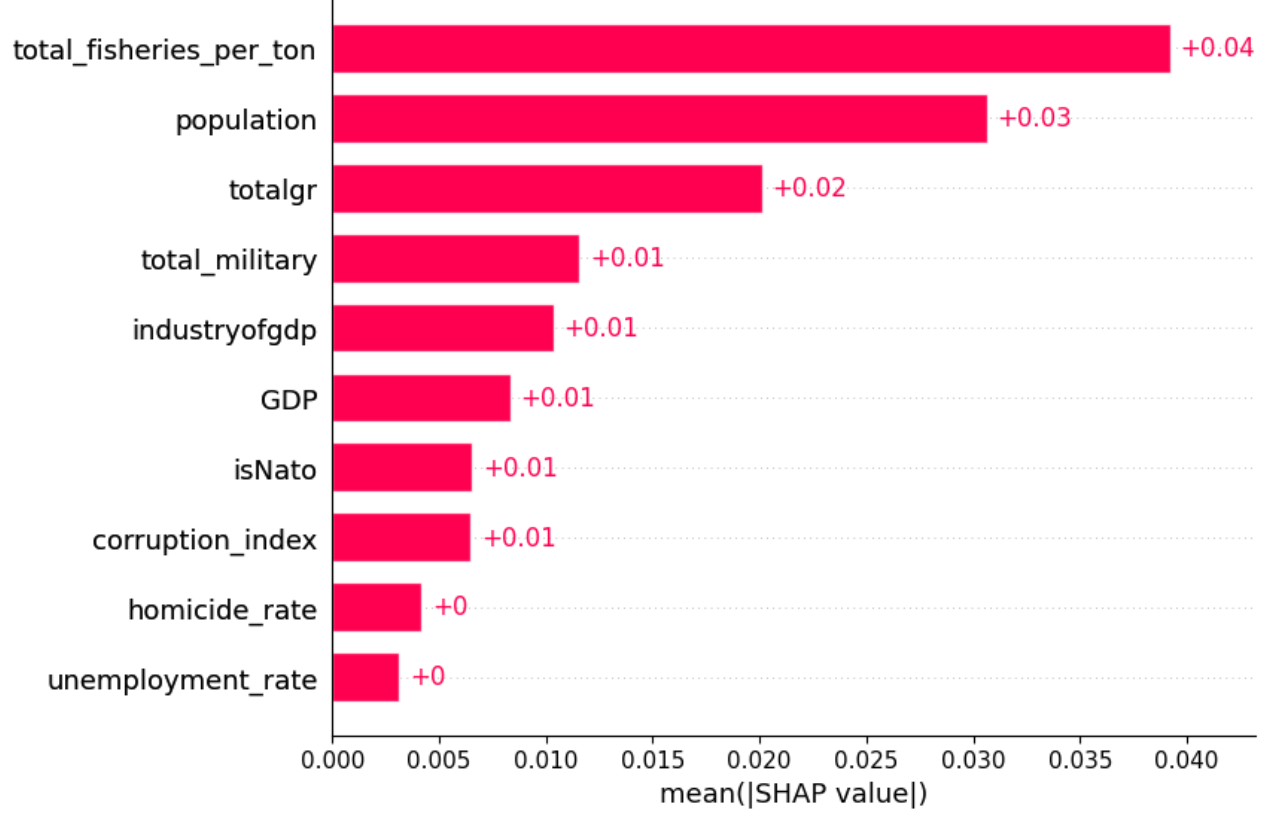

In [82]:
def imputation(sub_train, sub_train_describe_cols, imp = None):
    """
    Perform imputation of missing values.
    ________________
    Inputs:
    
    sub_train is the data frame;
    sub_train_describe_cols is the list of features;
    imp is the imputational model, we made the model for the training dataset 
    (in this case input imp is None) and apply it to both train and
    test dataset.
    
    ________________
    Return:
    
    wo_sub_train is the dataframe where we have imputed missing values;
    imp is the imputation model.
    """
    
    sub_train_describe_cols = [col for col in sub_train_describe_cols if col != 'normalised_sales']   

    
    X = sub_train[sub_train_describe_cols].values.copy()
    print("sub_train_describe_cols: ", sub_train_describe_cols)
    if imp is None:
       imp = IterativeImputer(max_iter=10, random_state=0)
       imp.fit(X)
        
    X = imp.transform(X)
    wo_sub_train = pd.DataFrame(X, columns = sub_train_describe_cols, index = sub_train.index)
    return wo_sub_train, imp

def auc_metric_fun(y_test, y_pred):
    ap = average_precision_score(y_test, y_pred, average="micro")
    return ap


def objective(inputs):
    """
    Compute the objective function for Bayesian Optimization given hyperparameters
    ________________
    Inputs:
    
    inputs is dictionary of hyperparameters, training dataset and other settings.
    
    ________________
    Return:
    
    params is the dictionary
    
    """    
    params = inputs.copy()
    
    X_train = params["X_train"]
    n_splits = params["n_splits"]
    test_size = params["test_size"]
    random_state = params["random_state"]    
    metric_fun = params["metric_fun"]
    model = params["model"]
    
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    
    output_label_name = params["output_label_name"]
    
    del params["X_train"], params["n_splits"], params["test_size"], params["random_state"], params["output_label_name"]   
    
    X = X_train.copy()
    y = X_train[[output_label_name]].copy()
    
    del params["metric_fun"], params["model"]
    del X[output_label_name]
    
    rf = model(**params)
    
    total = 0.0
    n = 0
    
    pred_total = []
    y_test_total = []
    
    metric_total = 0
    for train_index, test_index in ss.split(X):
        rf.fit(X.iloc[train_index], y.iloc[train_index])
        y_pred = rf.predict_proba(X.iloc[test_index])[:, 1]
        y_test = y.iloc[test_index][output_label_name].values.copy()
        
        pred_total += list(y_pred)
        y_test_total += list(y_test)
        
        metric = metric_fun(y_test, y_pred)
        metric_total += metric 
         
    loss = -metric_total
    
    params['loss'  ] = loss
    params['status'] = STATUS_OK
    #
    return params
        
def BO(MAX_EVALS, space, tpe_algorithm = tpe.suggest):
    """
    Main Bayesian Optimizationfunction
    ________________
    Inputs:
    
    MAX_EVALS is the number of iterations
    space is dict that contains the hyperparameters, training dataset and other settings. 
    tpe_algorith is the algorithm for surface optimization.
    
    ________________
    Return:
    
    bayes_trials_results[0] is the best hyperparameters that were found in Bayesian Optimization and
    the corresponding loss value.
    
    """ 
    
    bayes_trials = Trials()
    
     
      
    with warnings.catch_warnings():
                  warnings.simplefilter("ignore")
                  #
                  best = fmin(fn = objective, 
                              space = space, 
                              algo = tpe_algorithm, 
                              max_evals = MAX_EVALS, 
                              trials = bayes_trials,
                              rstate = np.random.seed(11))
                  bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
                  #
    return bayes_trials_results[0]

def feature_importance_shap(cols, X_train, bayes_trials_results, X_test = None):
    """
    Compute feature importance using SHAP measures
    ________________
    Inputs:
    
    cols is the list of features;
    X_train is the training dataset;
    bayes_trials_results is the hyperparameters obtained by Bayesian Optimization
    X_test is the test dataset, if it is None we use split of training dataset into train/test.
    
    ________________
    Return:
    
    no output
    """

    X = X_train[cols].copy()
    y = X_train["isPiracy"].copy()
    
    if X_test is None:
       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    else:
       X_train = X.copy() 
       y_train = y.copy()
        
    best_parameters = bayes_trials_results.copy()
    del best_parameters['loss'], best_parameters['status']

    model = RandomForestClassifier(**best_parameters)
    # Fits the model on the data
    model.fit(X_train, y_train)

    # Fits the explainer
    explainer = shap.Explainer(model.predict, X_test[cols])
    # Calculates the SHAP values - It takes some time
    shap_values = explainer(X_test[cols])
    shap.plots.bar(shap_values)
    shap.summary_plot(shap_values)

In [48]:
cols = list(indicators.keys()) + ["isPiracy", "isNato"]
train = US_Bases_indicators_pirate_attacks[cols].copy()

print("Columns with missing values: ", train.columns[train.isnull().any()])
missing = train.isnull().sum()
print(missing)

Columns with missing values:  Index(['corruption_index', 'homicide_rate', 'GDP', 'total_fisheries_per_ton',
       'total_military', 'unemployment_rate', 'totalgr', 'industryofgdp'],
      dtype='object')
corruption_index            31
homicide_rate              544
GDP                        168
total_fisheries_per_ton      5
total_military              50
population                   0
unemployment_rate           68
totalgr                    155
industryofgdp              182
isPiracy                     0
isNato                       0
dtype: int64


In [58]:
df, imp = imputation(train, cols, imp = None)
print("Columns with missing values: ", df.columns[df.isnull().any()])
missing = df.isnull().sum()
print(missing)

sub_train_describe_cols:  ['corruption_index', 'homicide_rate', 'GDP', 'total_fisheries_per_ton', 'total_military', 'population', 'unemployment_rate', 'totalgr', 'industryofgdp', 'isPiracy', 'isNato']
Columns with missing values:  Index([], dtype='object')
corruption_index           0
homicide_rate              0
GDP                        0
total_fisheries_per_ton    0
total_military             0
population                 0
unemployment_rate          0
totalgr                    0
industryofgdp              0
isPiracy                   0
isNato                     0
dtype: int64


In [77]:
n_features = df.shape[1] - 1
max_depth = list(range(1, n_features + 1)) + [None] 
max_features = list(range(1, n_features + 1)) + ["sqrt", "log2"]

space = {"n_estimators":      hp.choice(  "n_estimators",      range(10,  100, 10)    ),
         "max_depth":         hp.choice(  "max_depth",         max_depth              ),
         "max_features":      hp.choice(  "max_features",      max_features           ),
         "min_samples_split": hp.choice(  "min_samples_split", range(2,  10)          ),
         "min_samples_leaf":  hp.choice(  "min_samples_leaf",  range(1,  10)          ),
         "class_weight":      hp.choice(  "class_weight",      ["balanced_subsample"] ),
         
         "model":             hp.choice(  "model",             [RandomForestClassifier]),
         "metric_fun":        hp.choice(  "metric_fun",        [auc_metric_fun]       ),
         "criterion":         hp.choice(  "criterion",         ["gini"]               ),
         "n_jobs":            hp.choice(  'n_jobs',            [-1]                   ),             
         "random_state":      hp.choice(  "random_state",      [11]                   ),
              
         "X_train":           hp.choice(  "X_train",           [df]                   ),
         "output_label_name": hp.choice(  "output_label_name", ["isPiracy"]           ),
         "n_splits":          hp.choice(  "n_splits",          [5]                    ),
         "test_size":         hp.choice(  "test_size",         [0.2]                  )
        }

In [78]:
from sklearn.model_selection import ShuffleSplit
MAX_EVALS = 30
start = time()
bayes_trials_results = BO(MAX_EVALS, space, tpe_algorithm = tpe.suggest)
end = time()
print("Execution time: ", end - start)
all_metric_min = bayes_trials_results['loss']
bayes_trials_results

100%|███████████████████████| 30/30 [01:54<00:00,  3.81s/trial, best loss: -4.999747547081524]
Execution time:  114.38137221336365


{'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 20,
 'n_jobs': -1,
 'loss': -4.999747547081524,
 'status': 'ok'}

Exact explainer: 1461it [06:54,  3.53it/s]                                                    


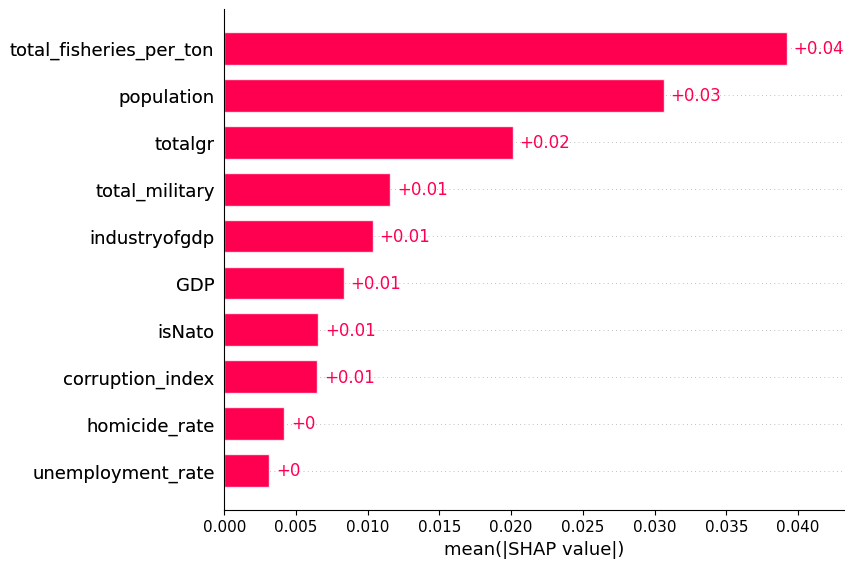

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


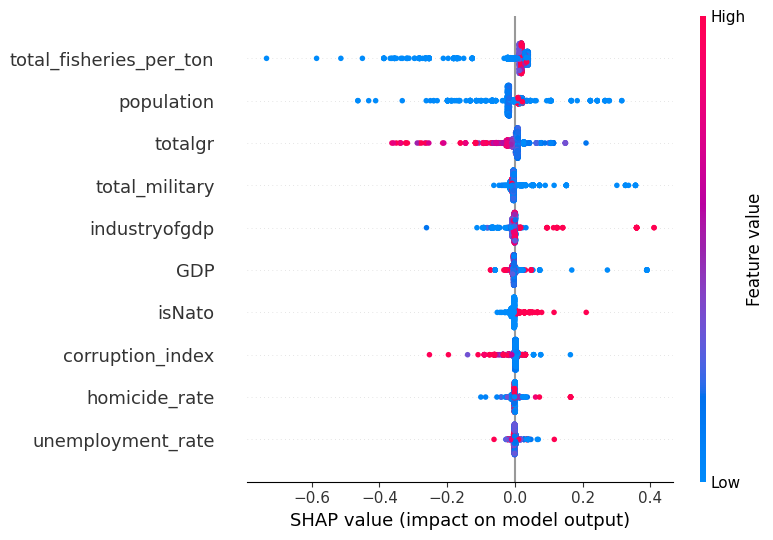

In [85]:
feature_names = list(indicators.keys()) + ["isNato"]
feature_importance_shap(feature_names, df, bayes_trials_results, X_test = None)